In [3]:
""" 
SOAR Offline Laptime Optimization for Reference Trajectory Generation
AA 203/273 Spring 2024
Andrew Wang, Bryan Yang
"""
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
from agents import BicycleVehicle
from config import *

In [4]:
%load_ext autoreload
%autoreload 2

In [45]:
# Set up track for optimization
veh_config = get_vehicle_config()
scene_config = get_scene_config(track_type=OVAL_TRACK)
veh_constraints = get_vehicle_opt_constraints(veh_config, scene_config)
track = scene_config["track"]

In [46]:
print(track.name)

OVAL w/Straight 1000, Curve Radius 250


In [ ]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

#     track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(10, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(10, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(10, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(10, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(10, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(10, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(10, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(10, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(10, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_s.set_xlabel('t')

#     vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

In [143]:
def compute_raceline(track, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config["lf"]
    lr = vehicle_config["lr"]

    mass = vehicle_config["m"]
    Iz = vehicle_config["Iz"]

#     tire_model = vehicle_config.tire_model

#     mu = vehicle_config.wheel_friction
#     Br = vehicle_config.pacejka_b_rear
#     Bf = vehicle_config.pacejka_b_front
#     Cr = vehicle_config.pacejka_c_rear
#     Cf = vehicle_config.pacejka_c_front
#     Dr = vehicle_config.pacejka_d_rear
#     Df = vehicle_config.pacejka_d_front

#     xu_ub = vehicle_constraints['xu_ub']
#     xu_lb = vehicle_constraints['xu_lb']
#     du_ub = vehicle_constraints['du_ub']
#     du_lb = vehicle_constraints['du_lb']

#     a_rate_max = du_ub.u_a
#     a_rate_min = du_lb.u_a

    c_alpha_f = vehicle_config["c"]
    c_alpha_r = vehicle_config["c"]
    
    Cd = veh_config["Cd"]
    SA = veh_config["SA"]
    
    v_long_max = vehicle_constraints["ub_vx"]
    v_long_min = vehicle_constraints["lb_vx"]
    v_tran_max = vehicle_constraints["ub_vy"]
    v_tran_min = vehicle_constraints["lb_vy"]
    psidot_max = vehicle_constraints["ub_omega"]
    psidot_min = vehicle_constraints["lb_omega"]
    e_psi_max = vehicle_constraints["ub_epsi"]
    e_psi_min = vehicle_constraints["lb_epsi"]
    e_y_max = vehicle_constraints["ub_ey"]
    e_y_min = vehicle_constraints["lb_ey"]
    steer_max = vehicle_constraints["ub_delta"]
    steer_min = vehicle_constraints["lb_delta"]

    a_max = vehicle_config["max_accel"]
    a_min = -vehicle_config["max_accel"]
    steer_rate_max = vehicle_config["max_steer_rate"]
    steer_rate_min = -vehicle_config["max_steer_rate"]


    print('=================== Raceline computation ===================')
    print('Track name: %s' % track.name)
    print('     - length: %g m' % track.total_len)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - Drag Coefficient: %g' % Cd)
    print('     - frontal area: %g m^2' % SA)
    print('     - Front Tire Coefficient : %g N/rad' % c_alpha_f)
    print('     - Rear Tire Coefficient : %g N/rad' % c_alpha_r)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.total_len)
    m.s = ContinuousSet(bounds=(0, m.sf), initialize=np.linspace(0, track.total_len, 200))                             #s

    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
#     m.u1 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=8) #vx
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=1)    #vy
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)    #omega
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max), initialize=0)    #epsi
    def _t_init(m, s):
        return s/track.total_len * 30
    m.x4 = Var(m.s, bounds=(0, 2000), initialize=_t_init)                  #t
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=7)          #ey
    m.x6 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)      #delta

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.dx6ds = DerivativeVar(m.x6, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
    m.obj = Objective(expr=m.x4[m.sf], sense=minimize) # + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
#     m.obj = Objective(expr=m.x4[m.sf] + 10000*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    # ways to tune the cost:
        # penalize u1
        # penalize u2
        # penalize u1 and u2
        # vary the penalizations on u1 and u2
        # penalize the input rate
    # to do: write this optimization problem as a function that gets called
    # different arguments will choose a different objective tuning
    # function output should be the DF, then we can store them all

    #sideslip and lateral force
    def _alphafc(m, s):
#         return m.alpha_f[s] == m.u1[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
        # alpha = delta - atan((vy+lf*w)/vx)
        return m.alpha_f[s] == m.x6[s] - atan((m.x1[s] + lf*m.x2[s]) / (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        # alpha = - atan((vy-lr*w)/vx)
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)
    
    def sdot_inv(m, s, cur):
        return (1 - cur*m.x5[s]) / (eps + m.x0[s]*cos(m.x3[s]) - m.x1[s]*sin(m.x3[s]))
        
    def _Fyfc(m, s):
#         return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        return m.Fyf[s] ==  c_alpha_f * m.alpha_f[s]
    m.c2 = Constraint(m.s, rule=_Fyfc)
    def _Fyrc(m, s):
#         return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        return m.Fyr[s] ==  c_alpha_r * m.alpha_r[s]
    m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.getCurvature(s)
        # dvx/ds = vxdot/sdot = (a - (Fd/m + Fyfsin(delta)/m + omega*vy)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
#         return m.dx0ds[s] == m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) - (0.5*Cd*SA*m.x0[s]**2/mass) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
        return m.dx0ds[s] == (m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) + m.x2[s]*m.x1[s])) * sdot_inv(m, s, cur)
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.getCurvature(s)
        # dvy/ds = vydot/sdot = 1/m*(Fyfcos(delta)+Fyr) - omega*vx)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx1ds[s] == ((m.Fyf[s]*cos(m.x6[s]) + m.Fyr[s])/mass - m.x2[s]*m.x0[s]) * sdot_inv(m, s, cur)
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = wdot/sdot = 1/Iz*(lf*Fyfcos(delta) - lrFyr)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx2ds[s] == ((lf*m.Fyf[s]*cos(m.x6[s]) - lr*m.Fyr[s])/Iz) * sdot_inv(m, s, cur)
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = epsidot/sdot = (omega - kappa*sdot)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx3ds[s] == (m.x2[s]*sdot_inv(m, s, cur) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.getCurvature(s)
        # dt/ds = 1/sdot = (1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx4ds[s] == sdot_inv(m, s, cur)
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.getCurvature(s)
        # dey/ds = eydot/sdot = (vxsin(epsi) + vycos(epsi))*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx5ds[s] == (m.x0[s]*sin(m.x3[s]) + m.x1[s]*cos(m.x3[s])) * sdot_inv(m, s, cur)
    m.x5dot = Constraint(m.s, rule=_x5dot)
    
    def _x6dot(m, s):
        cur = track.getCurvature(s)
        # ddelta/ds = deltadot/sdot = (ddelta)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx6ds[s] == m.u1[s]*sdot_inv(m, s, cur)
    m.x6dot = Constraint(m.s, rule=_x6dot)

    # rate constraints on acceleration
#     def _u0dotmax(m, s):
#         cur = track.getCurvature(s)
#         return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotub = Constraint(m.s, rule=_u0dotmax)
#     def _u0dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

#     rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
        yield m.x0[0] == m.x0[track.total_len] #vx
        yield m.x1[0] == m.x1[track.total_len] #vy
        yield m.x2[0] == m.x2[track.total_len] #w
        yield m.x3[0] == m.x3[track.total_len] #epsi
        yield m.x4[0] == 0 #t
        yield m.x5[0] == m.x5[track.total_len] #ey
        yield m.x6[0] == m.x6[track.total_len] #delta
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
#     TransformationFactory('dae.collocation').apply_to(m, nfe=200, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD
    TransformationFactory('dae.collocation').apply_to(m, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 10000
    print("new")
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'delta' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec)),
               }

    for j in range(len(s_vec)):
        s = s_vec[j]
        
        vx = value(m.x0[s])
        vy = value(m.x1[s])
        w = value(m.x2[s])
        epsi = value(m.x3[s])
        t = value(m.x4[s])
        ey = value(m.x5[s])
        delta = value(m.x6[s])
        accel = value(m.u0[s])
        ddelta = value(m.u1[s])
        
        cl_state = np.array([s, ey, epsi, vx, vy, w, delta])
        global_state = track.CLtoGlobal(cl_state)
        x, y, theta, vx_g, vy_g, w_g, delta_g = global_state

        raceline['t'][j] = t
        raceline['v_long'][j] = vx
        raceline['v_tran'][j] = vy
        raceline['psidot'][j] = w
        raceline['s'][j] = s
        raceline['e_y'][j] = ey
        raceline['e_psi'][j] = epsi
        raceline['delta'][j] = delta
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = theta
        raceline['u_a'][j] = accel
        raceline['u_s'][j] = ddelta

    return raceline, model



In [144]:
raceline, model = compute_raceline(track, veh_config, veh_constraints)

=================== Raceline computation ===================
Track name: OVAL w/Straight 1000, Curve Radius 250
     - length: 3570.8 m
     - width: 20 m
Vehicle configuration:
     - center of mass to front axle: 2 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 50 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
of finite elements specified in apply. The larger number of finite elements
will be used.
new
Ipopt 3.13.4: max_iter=10000


******************************************************************************
This program contains I

  77  1.0085455e+02 6.74e-02 1.16e+02  -1.0 2.18e+03    -  5.93e-02 9.60e-02f  1
  78  1.0277588e+02 6.54e-02 1.22e+02  -1.0 2.16e+03    -  1.20e-01 3.02e-02f  2
  79  1.0278603e+02 6.54e-02 5.93e+02  -1.0 1.02e+02   3.1 3.72e-02 1.51e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0294750e+02 6.52e-02 3.56e+04  -1.0 1.02e+02   2.6 6.06e-02 2.41e-03h  1
  81  1.0375032e+02 6.44e-02 3.77e+05  -1.0 1.05e+02   2.2 7.25e-02 1.21e-02h  1
  82  1.0413441e+02 6.40e-02 4.25e+05  -1.0 1.64e+02   1.7 6.63e-02 6.20e-03h  1
  83  1.0446679e+02 6.37e-02 4.73e+05  -1.0 9.79e+01   2.1 1.24e-01 5.31e-03h  1
  84  1.0498729e+02 6.32e-02 5.25e+05  -1.0 1.97e+02   1.6 4.33e-02 8.59e-03h  2
  85  1.0589544e+02 6.22e-02 8.00e+05  -1.0 1.02e+02   2.1 8.75e-02 1.51e-02h  2
  86  1.0650140e+02 6.16e-02 1.06e+06  -1.0 9.13e+01   2.5 9.87e-02 1.05e-02h  2
  87  1.0665384e+02 6.14e-02 1.06e+06  -1.0 1.27e+02   2.0 5.24e-02 2.80e-03h  1
  88  1.0695721e+02 6.11e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2939028e+02 1.06e-01 5.69e+06  -1.0 1.04e+02   0.3 2.27e-02 1.93e-02h  1
 171  1.2968701e+02 1.05e-01 5.71e+06  -1.0 8.63e+01   0.7 2.92e-02 1.11e-02h  1
 172  1.2999276e+02 1.04e-01 5.46e+06  -1.0 8.81e+01   0.2 4.53e-02 1.25e-02h  1
 173  1.3000801e+02 1.04e-01 5.51e+06  -1.0 7.73e+01   0.6 5.51e-02 5.56e-04h  1
 174  1.3020840e+02 1.03e-01 5.26e+06  -1.0 1.68e+02   0.2 4.26e-02 7.96e-03h  3
 175  1.3097743e+02 1.00e-01 5.12e+06  -1.0 7.57e+01   0.6 1.29e-02 2.78e-02h  1
 176  1.3104538e+02 9.97e-02 5.24e+06  -1.0 6.82e+01   1.0 1.43e-02 2.55e-03h  1
 177  1.3179316e+02 9.69e-02 5.14e+06  -1.0 6.99e+01   0.5 6.86e-03 2.84e-02h  1
 178  1.3182133e+02 9.68e-02 5.26e+06  -1.0 5.96e+01   1.0 2.17e-02 1.11e-03h  1
 179  1.3240774e+02 9.45e-02 5.17e+06  -1.0 6.14e+01   0.5 1.67e-02 2.42e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.3243579e+02 9.44e-02

 262  1.4426580e+02 4.64e-02 3.14e+06  -1.0 1.39e+01   1.5 1.50e-03 9.32e-04h  1
 263  1.4429010e+02 4.63e-02 3.13e+06  -1.0 1.26e+01   2.0 3.34e-03 2.17e-03h  1
 264  1.4459137e+02 4.50e-02 3.14e+06  -1.0 1.43e+01   1.5 1.15e-04 2.80e-02h  1
 265  1.4460090e+02 4.50e-02 3.14e+06  -1.0 1.37e+01   1.9 1.03e-02 8.96e-04h  1
 266  1.4480762e+02 4.40e-02 3.10e+06  -1.0 2.38e+01   1.4 1.44e-02 2.04e-02h  1
 267  1.4481200e+02 4.40e-02 3.09e+06  -1.0 1.39e+01   1.9 4.57e-03 4.25e-04h  1
 268  1.4490453e+02 4.36e-02 3.07e+06  -1.0 2.86e+01   1.4 8.75e-03 9.45e-03h  1
 269  1.4517554e+02 4.24e-02 3.02e+06  -1.0 1.43e+01   1.8 1.88e-03 2.65e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.4517834e+02 4.24e-02 3.02e+06  -1.0 4.61e+01   1.3 2.24e-04 3.19e-04h  1
 271r 1.4517834e+02 4.24e-02 1.00e+03  -1.0 0.00e+00   1.8 0.00e+00 2.97e-07R  5
 272r 1.4522010e+02 1.04e-02 1.20e+03  -1.0 4.70e+02    -  6.26e-02 2.44e-03f  1
 273  1.4835484e+02 7.20e-02

 355  1.5403815e+02 1.29e-04 1.55e-02  -3.8 2.16e-01  -1.7 1.00e+00 1.00e+00f  1
 356  1.5394697e+02 4.88e-04 2.88e-01  -3.8 6.56e-01  -2.2 1.00e+00 6.40e-01f  1
 357  1.5389609e+02 1.06e-04 6.22e-02  -3.8 1.91e-01  -1.8 1.00e+00 1.00e+00f  1
 358  1.5387660e+02 1.70e-05 2.16e-02  -3.8 8.55e-02  -1.4 1.00e+00 1.00e+00h  1
 359  1.5381816e+02 1.53e-04 1.05e-02  -3.8 2.52e-01  -1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.5379662e+02 1.99e-05 7.32e-03  -3.8 8.76e-02  -1.4 1.00e+00 1.00e+00h  1
 361  1.5373216e+02 1.67e-04 2.73e-02  -3.8 2.67e-01  -1.9 1.00e+00 1.00e+00f  1
 362  1.5370803e+02 2.34e-05 3.48e-03  -3.8 9.88e-02  -1.5 1.00e+00 1.00e+00h  1
 363  1.5363579e+02 1.96e-04 2.19e-02  -3.8 2.97e-01  -1.9 1.00e+00 1.00e+00f  1
 364  1.5360875e+02 2.72e-05 3.43e-03  -3.8 1.10e-01  -1.5 1.00e+00 1.00e+00h  1
 365  1.5352792e+02 2.19e-04 2.95e-02  -3.8 3.28e-01  -2.0 1.00e+00 1.00e+00f  1
 366  1.5349786e+02 2.78e-05

 448  1.5028630e+02 1.88e-06 2.63e-03  -3.8 7.81e-02  -1.5 1.00e+00 1.00e+00f  1
 449  1.5027957e+02 2.67e-07 2.63e-03  -3.8 2.93e-02  -1.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  1.5025941e+02 2.39e-06 2.63e-03  -3.8 8.79e-02  -1.5 1.00e+00 1.00e+00f  1
 451  1.5025185e+02 3.40e-07 2.63e-03  -3.8 3.29e-02  -1.1 1.00e+00 1.00e+00h  1
 452  1.5022919e+02 3.05e-06 2.63e-03  -3.8 9.88e-02  -1.6 1.00e+00 1.00e+00f  1
 453  1.5022069e+02 4.34e-07 2.63e-03  -3.8 3.71e-02  -1.1 1.00e+00 1.00e+00h  1
 454  1.5019522e+02 3.88e-06 2.63e-03  -3.8 1.11e-01  -1.6 1.00e+00 1.00e+00f  1
 455  1.5018567e+02 5.55e-07 2.63e-03  -3.8 4.17e-02  -1.2 1.00e+00 1.00e+00h  1
 456  1.5015704e+02 4.96e-06 2.63e-03  -3.8 1.25e-01  -1.7 1.00e+00 1.00e+00f  1
 457  1.5014630e+02 7.10e-07 2.63e-03  -3.8 4.69e-02  -1.3 1.00e+00 1.00e+00h  1
 458  1.5011413e+02 6.34e-06 2.63e-03  -3.8 1.41e-01  -1.7 1.00e+00 1.00e+00f  1
 459  1.4987189e+02 3.77e-04

 541  1.4774233e+02 1.87e-06 2.62e-03  -3.8 6.17e-02  -1.4 1.00e+00 1.00e+00f  1
 542  1.4773783e+02 2.65e-07 2.62e-03  -3.8 2.31e-02  -0.9 1.00e+00 1.00e+00h  1
 543  1.4772437e+02 2.37e-06 2.62e-03  -3.8 6.94e-02  -1.4 1.00e+00 1.00e+00f  1
 544  1.4771933e+02 3.36e-07 2.62e-03  -3.8 2.60e-02  -1.0 1.00e+00 1.00e+00h  1
 545  1.4770423e+02 3.01e-06 2.62e-03  -3.8 7.80e-02  -1.5 1.00e+00 1.00e+00f  1
 546  1.4769858e+02 4.26e-07 2.62e-03  -3.8 2.93e-02  -1.0 1.00e+00 1.00e+00h  1
 547  1.4768165e+02 3.81e-06 2.62e-03  -3.8 8.78e-02  -1.5 1.00e+00 1.00e+00f  1
 548  1.4767531e+02 5.40e-07 2.62e-03  -3.8 3.29e-02  -1.1 1.00e+00 1.00e+00h  1
 549  1.4767293e+02 7.56e-08 2.62e-03  -3.8 1.23e-02  -0.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  1.4766581e+02 6.79e-07 2.62e-03  -3.8 3.70e-02  -1.2 1.00e+00 1.00e+00f  1
 551  1.4760228e+02 5.48e-05 2.62e-03  -3.8 3.33e-01  -2.1 1.00e+00 1.00e+00f  1
 552  1.4759930e+02 1.45e-07

 634  1.4609426e+02 1.48e-07 2.57e-03  -3.8 3.64e-02  -1.2 1.00e+00 1.00e+00f  1
 635  1.4605092e+02 1.20e-05 2.56e-03  -3.8 3.27e-01  -2.1 1.00e+00 1.00e+00f  1
 636  1.4604888e+02 3.03e-08 2.56e-03  -3.8 1.53e-02  -0.8 1.00e+00 1.00e+00h  1
 637  1.4604279e+02 2.34e-07 2.56e-03  -3.8 4.60e-02  -1.3 1.00e+00 1.00e+00f  1
 638  1.4604051e+02 3.31e-08 2.56e-03  -3.8 1.73e-02  -0.8 1.00e+00 1.00e+00h  1
 639  1.4603368e+02 2.98e-07 2.56e-03  -3.8 5.18e-02  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.4603112e+02 4.22e-08 2.56e-03  -3.8 1.94e-02  -0.9 1.00e+00 1.00e+00h  1
 641  1.4600822e+02 3.44e-06 2.56e-03  -3.8 1.75e-01  -1.8 1.00e+00 1.00e+00f  1
 642  1.4600714e+02 8.31e-09 2.56e-03  -3.8 8.18e-03  -0.5 1.00e+00 1.00e+00h  1
 643  1.4600392e+02 6.85e-08 2.56e-03  -3.8 2.46e-02  -1.0 1.00e+00 1.00e+00f  1
 644  1.4597521e+02 5.64e-06 2.56e-03  -3.8 2.21e-01  -1.9 1.00e+00 1.00e+00f  1
 645  1.4597386e+02 1.39e-08

 727  1.3815239e+02 8.44e-03 2.25e+00  -3.8 3.61e+01  -4.3 2.87e-01 1.54e-01f  1
 728  1.3792398e+02 6.17e-03 8.37e-01  -3.8 1.08e+01  -3.8 2.33e-01 4.47e-01f  1
 729  1.3767130e+02 9.25e-03 2.49e+00  -3.8 3.23e+01  -4.3 1.08e-01 1.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.3756176e+02 7.31e-03 1.78e+00  -3.8 1.22e+01  -3.9 3.23e-01 2.10e-01f  1
 731  1.3740868e+02 7.07e-03 1.76e+00  -3.8 3.54e+01  -4.4 4.73e-01 1.04e-01f  1
 732  1.3721346e+02 6.73e-03 1.28e+00  -3.8 1.36e+01  -3.9 7.66e-01 3.64e-01f  1
 733  1.3689878e+02 1.14e-02 2.11e+00  -3.8 3.81e+01  -4.4 3.72e-01 2.19e-01f  1
 734  1.3683803e+02 1.01e-02 1.85e+00  -3.8 1.42e+01  -4.0 5.60e-01 1.13e-01h  1
 735  1.3656212e+02 7.03e-03 5.49e+00  -3.8 4.44e+01  -4.5 6.79e-02 1.86e-01f  1
 736  1.3641894e+02 9.91e-03 5.44e+00  -3.8 8.97e+01  -4.5 1.37e-01 8.12e-02f  1
 737  1.3624052e+02 9.76e-03 4.08e+00  -3.8 1.75e+01  -4.1 3.35e-01 2.79e-01f  1
 738  1.3607763e+02 2.64e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.2961306e+02 3.32e-05 1.34e+00  -5.7 5.35e+00  -3.9 8.90e-01 5.14e-01f  1
 821  1.2949453e+02 1.56e-04 9.76e-01  -5.7 1.56e+01  -4.4 2.75e-01 3.61e-01f  1
 822  1.2945905e+02 1.23e-04 6.99e-01  -5.7 5.91e+00  -4.0 3.54e-01 2.90e-01f  1
 823  1.2934790e+02 2.10e-04 5.53e-01  -5.7 1.72e+01  -4.4 6.09e-01 3.07e-01f  1
 824  1.2932702e+02 1.81e-04 4.12e-01  -5.7 6.54e+00  -4.0 5.70e-01 1.58e-01f  1
 825  1.2921782e+02 2.67e-04 2.88e-01  -5.7 1.91e+01  -4.5 5.46e-01 2.78e-01f  1
 826  1.2914598e+02 1.95e-04 3.71e-01  -5.7 7.25e+00  -4.1 1.00e+00 4.89e-01f  1
 827  1.2911333e+02 9.14e-05 1.90e-01  -5.7 2.73e+00  -3.6 1.00e+00 5.97e-01f  1
 828  1.2904954e+02 1.04e-04 3.85e-01  -5.7 8.06e+00  -4.1 1.00e+00 3.90e-01f  1
 829  1.2897533e+02 1.60e-04 4.09e-01  -5.7 2.33e+01  -4.6 1.00e+00 1.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  1.2882154e+02 3.46e-04

 912  1.2170959e+02 6.34e-04 1.49e+00  -5.7 7.62e+01  -5.4 1.54e-01 2.48e-02f  1
 913  1.2170067e+02 5.43e-04 1.89e+00  -5.7 3.93e+00  -4.1 3.40e-01 1.46e-01f  1
 914  1.2162148e+02 3.87e-04 8.29e-01  -5.7 1.17e+01  -4.5 1.35e-01 4.33e-01f  1
 915  1.2137516e+02 9.91e-04 9.06e-01  -5.7 3.38e+01  -5.0 2.14e-01 4.56e-01f  1
 916  1.2122986e+02 1.02e-03 5.06e-01  -5.7 3.71e+01  -5.1 3.26e-01 2.46e-01f  1
 917  1.2118425e+02 8.38e-04 4.15e-01  -5.7 1.42e+01  -4.6 1.95e-01 2.06e-01f  1
 918  1.2111789e+02 8.60e-04 2.87e-01  -5.7 1.12e+02  -5.6 1.21e-01 3.59e-02f  1
 919  1.2105120e+02 7.76e-04 3.30e-01  -5.7 4.56e+01  -5.2 3.88e-02 9.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.2104056e+02 5.29e-04 2.21e-01  -5.7 2.24e+00  -3.8 6.67e-01 3.19e-01f  1
 921  1.2093719e+02 1.07e-04 2.51e-01  -5.7 6.69e+00  -4.3 3.54e-01 1.00e+00f  1
 922  1.2078994e+02 2.67e-04 1.05e-01  -5.7 1.96e+01  -4.8 3.85e-01 4.80e-01f  1
 923  1.2074606e+02 1.83e-04

1005  1.1734024e+02 1.47e-06 2.53e-04  -5.7 7.30e-01  -3.5 1.00e+00 1.00e+00f  1
1006  1.1733654e+02 2.06e-07 2.53e-04  -5.7 2.74e-01  -3.0 1.00e+00 1.00e+00h  1
1007  1.1732545e+02 1.85e-06 2.53e-04  -5.7 8.21e-01  -3.5 1.00e+00 1.00e+00f  1
1008  1.1729223e+02 1.70e-05 2.52e-04  -5.7 2.46e+00  -4.0 1.00e+00 1.00e+00f  1
1009  1.1722887e+02 7.13e-05 1.91e-02  -5.7 7.31e+00  -4.5 7.41e-01 6.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010  1.1716914e+02 1.52e-04 5.69e-02  -5.7 6.19e+01  -5.4 6.26e-02 7.02e-02f  1
1011  1.1716624e+02 6.41e-05 9.81e-01  -5.7 3.85e-01  -3.2 1.00e+00 5.79e-01f  1
1012  1.1715079e+02 4.22e-06 7.42e-01  -5.7 1.15e+00  -3.7 6.06e-01 1.00e+00f  1
1013  1.1714499e+02 6.19e-07 2.49e-04  -5.7 4.32e-01  -3.2 1.00e+00 1.00e+00h  1
1014  1.1712759e+02 5.25e-06 2.49e-04  -5.7 1.30e+00  -3.7 1.00e+00 1.00e+00f  1
1015  1.1712107e+02 7.28e-07 2.49e-04  -5.7 4.86e-01  -3.3 1.00e+00 1.00e+00h  1
1016  1.1711088e+02 2.01e-06

1098  1.1463439e+02 4.77e-04 4.57e-01  -5.7 3.34e+01  -5.2 4.71e-02 1.92e-01f  1
1099  1.1450894e+02 8.56e-04 3.38e-01  -5.7 3.72e+01  -5.3 3.06e-01 2.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1445933e+02 9.45e-04 3.06e-01  -5.7 4.13e+01  -5.3 5.46e-02 9.29e-02f  1
1101  1.1443443e+02 2.07e-05 2.31e+01  -5.7 2.00e+00  -4.0 1.50e-01 1.00e+00f  1
1102  1.1442495e+02 2.59e-06 2.03e-04  -5.7 7.46e-01  -3.6 1.00e+00 1.00e+00h  1
1103  1.1439654e+02 2.37e-05 1.37e-03  -5.7 2.24e+00  -4.0 1.00e+00 9.99e-01f  1
1104  1.1435728e+02 6.40e-05 4.36e-01  -5.7 6.69e+00  -4.5 9.88e-01 4.62e-01f  1
1105  1.1433945e+02 1.50e-03 4.29e-01  -5.7 1.14e+02  -5.5 1.13e-02 2.30e-02f  1
1106  1.1433756e+02 1.42e-03 3.34e+00  -5.7 2.82e+00  -4.1 8.30e-01 5.35e-02f  1
1107  1.1423137e+02 4.73e-04 1.86e+00  -5.7 8.42e+00  -4.6 4.46e-01 1.00e+00f  1
1108  1.1411652e+02 7.37e-04 1.49e+00  -5.7 9.39e+00  -4.7 2.03e-01 9.73e-01f  1
1109  1.1411522e+02 5.58e-04

1191  1.1220362e+02 8.80e-06 1.47e+00  -5.7 2.19e+00  -4.1 3.99e-01 1.00e+00f  1
1192  1.1212997e+02 7.08e-05 1.62e-01  -5.7 6.55e+00  -4.6 5.37e-01 1.00e+00f  1
1193  1.1212882e+02 7.05e-05 8.19e-01  -5.7 1.93e+01  -5.0 2.69e-01 5.31e-03h  1
1194  1.1210881e+02 5.91e-05 3.55e-01  -5.7 7.36e+00  -4.6 9.77e-02 2.49e-01f  1
1195  1.1204234e+02 1.16e-04 1.81e-01  -5.7 2.18e+01  -5.1 3.34e-01 2.77e-01f  1
1196  1.1199875e+02 9.04e-05 6.81e+00  -5.7 8.26e+00  -4.7 9.03e-02 4.88e-01f  1
1197  1.1190446e+02 1.52e-04 1.04e+00  -5.7 9.22e+00  -4.7 3.30e-01 9.35e-01f  1
1198  1.1188726e+02 8.74e-05 6.98e-01  -5.7 3.44e+00  -4.3 3.09e-01 4.60e-01f  1
1199  1.1167397e+02 9.03e-04 4.45e-01  -5.7 3.03e+01  -5.3 3.07e-01 6.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.1167260e+02 8.19e-04 1.12e+00  -5.7 1.90e+00  -3.9 1.54e-01 9.33e-02f  1
1201  1.1166753e+02 8.73e-07 2.64e-04  -5.7 5.36e-01  -3.5 1.00e+00 1.00e+00f  1
1202  1.1164997e+02 5.76e-06

1284  1.0791012e+02 4.76e-04 8.61e-03  -5.7 3.74e+00  -4.5 6.24e-01 5.38e-01f  1
1285  1.0786294e+02 2.79e-04 1.11e-02  -5.7 1.12e+01  -4.9 3.52e-01 4.26e-01f  1
1286  1.0783057e+02 6.44e-05 9.27e-03  -5.7 4.19e+00  -4.5 1.00e+00 7.81e-01f  1
1287  1.0781507e+02 5.04e-06 4.78e-02  -5.7 1.57e+00  -4.1 3.74e-01 1.00e+00f  1
1288  1.0780924e+02 7.13e-07 1.31e-04  -5.7 5.89e-01  -3.7 1.00e+00 1.00e+00h  1
1289  1.0779815e+02 3.04e-06 2.00e-01  -5.7 1.76e+00  -4.1 1.00e+00 6.35e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290  1.0777235e+02 1.69e-05 5.43e-01  -5.7 5.28e+00  -4.6 4.26e-01 4.96e-01f  1
1291  1.0775285e+02 9.29e-06 1.30e-04  -5.7 1.98e+00  -4.2 1.00e+00 1.00e+00f  1
1292  1.0771505e+02 3.84e-05 5.21e-01  -5.7 5.91e+00  -4.7 5.08e-01 6.48e-01f  1
1293  1.0769323e+02 1.19e-05 1.30e-04  -5.7 2.22e+00  -4.2 1.00e+00 1.00e+00f  1
1294  1.0768505e+02 1.67e-06 1.30e-04  -5.7 8.31e-01  -3.8 1.00e+00 1.00e+00h  1
1295  1.0768198e+02 2.35e-07

1377  1.0503127e+02 1.05e-07 1.10e-04  -5.7 2.36e-01  -3.3 1.00e+00 1.00e+00h  1
1378  1.0501326e+02 8.16e-06 1.10e-04  -5.7 2.12e+00  -4.3 1.00e+00 1.00e+00f  1
1379  1.0500457e+02 6.57e-06 7.83e-03  -5.7 2.38e+00  -4.3 1.00e+00 4.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380  1.0494412e+02 9.36e-05 1.93e-04  -5.7 7.12e+00  -4.8 1.00e+00 1.00e+00f  1
1381  1.0493084e+02 4.30e-05 1.02e-02  -5.7 2.67e+00  -4.4 1.00e+00 5.90e-01h  1
1382  1.0486805e+02 1.07e-04 1.10e-01  -5.7 7.97e+00  -4.9 2.78e-01 9.31e-01f  1
1383  1.0486498e+02 2.80e-07 1.09e-04  -5.7 3.74e-01  -3.5 1.00e+00 1.00e+00f  1
1384  1.0486380e+02 3.74e-08 1.09e-04  -5.7 1.40e-01  -3.1 1.00e+00 1.00e+00h  1
1385  1.0486025e+02 3.34e-07 1.09e-04  -5.7 4.20e-01  -3.6 1.00e+00 1.00e+00f  1
1386  1.0482835e+02 2.71e-05 1.08e-04  -5.7 3.77e+00  -4.5 1.00e+00 1.00e+00f  1
1387  1.0482688e+02 6.10e-08 1.08e-04  -5.7 1.77e-01  -3.2 1.00e+00 1.00e+00h  1
1388  1.0481345e+02 4.82e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470  1.0398030e+02 6.61e-08 9.22e-05  -5.7 2.52e-01  -3.4 1.00e+00 1.00e+00f  1
1471  1.0397943e+02 9.30e-09 9.22e-05  -5.7 9.44e-02  -3.0 1.00e+00 1.00e+00h  1
1472  1.0397685e+02 8.38e-08 9.22e-05  -5.7 2.83e-01  -3.5 1.00e+00 1.00e+00f  1
1473  1.0397588e+02 1.18e-08 9.22e-05  -5.7 1.06e-01  -3.1 1.00e+00 1.00e+00h  1
1474  1.0397552e+02 1.66e-09 9.22e-05  -5.7 3.98e-02  -2.6 1.00e+00 1.00e+00h  1
1475  1.0397443e+02 1.49e-08 9.22e-05  -5.7 1.19e-01  -3.1 1.00e+00 1.00e+00f  1
1476  1.0396462e+02 1.22e-06 9.21e-05  -5.7 1.07e+00  -4.1 1.00e+00 1.00e+00f  1
1477  1.0391891e+02 2.86e-05 2.02e-03  -5.7 9.60e+00  -5.0 4.47e-01 5.20e-01f  1
1478  1.0388607e+02 1.57e-05 9.16e-05  -5.7 3.60e+00  -4.6 1.00e+00 1.00e+00f  1
1479  1.0387377e+02 2.18e-06 9.15e-05  -5.7 1.35e+00  -4.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  1.0383691e+02 1.96e-05

1562  1.0200118e+02 1.14e-04 2.13e-03  -5.7 1.60e+01  -5.3 3.75e-01 4.99e-01f  1
1563  1.0200032e+02 9.93e-05 6.87e-01  -5.7 7.55e-01  -4.0 7.44e-01 1.32e-01f  1
1564  1.0198088e+02 1.13e-05 8.15e-05  -5.7 2.26e+00  -4.4 1.00e+00 1.00e+00f  1
1565  1.0195681e+02 1.96e-05 5.21e-03  -5.7 6.77e+00  -4.9 4.21e-01 4.13e-01f  1
1566  1.0194761e+02 1.86e-05 5.99e-01  -5.7 7.75e+00  -5.0 2.47e-01 1.46e-01f  1
1567  1.0193734e+02 1.34e-05 2.24e-01  -5.7 2.96e+00  -4.5 1.71e-01 4.29e-01f  1
1568  1.0192837e+02 2.06e-06 1.25e-04  -5.7 1.10e+00  -4.1 1.00e+00 1.00e+00f  1
1569  1.0190317e+02 1.60e-05 2.34e-01  -5.7 3.32e+00  -4.6 3.91e-01 9.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570  1.0187247e+02 3.63e-05 1.79e-01  -5.7 2.93e+01  -5.6 2.09e-01 1.29e-01f  1
1571  1.0183679e+02 5.97e-05 6.90e-02  -5.7 1.11e+01  -5.1 1.00e+00 3.98e-01f  1
1572  1.0182401e+02 4.20e-05 8.24e-02  -5.7 4.18e+00  -4.7 1.00e+00 3.82e-01f  1
1573  1.0181147e+02 4.86e-06

1655  1.0052396e+02 6.00e-07 4.75e-01  -5.7 4.98e+00  -4.8 6.75e-01 3.10e-01f  1
1656  1.0051186e+02 4.87e-07 7.50e-05  -5.7 1.86e+00  -4.4 1.00e+00 1.00e+00f  1
1657  1.0050733e+02 6.84e-08 7.52e-05  -5.7 6.98e-01  -4.0 1.00e+00 1.00e+00h  1
1658  1.0049374e+02 6.14e-07 7.51e-05  -5.7 2.09e+00  -4.4 1.00e+00 1.00e+00f  1
1659  1.0048865e+02 8.61e-08 7.50e-05  -5.7 7.84e-01  -4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660  1.0048675e+02 1.21e-08 7.50e-05  -5.7 2.94e-01  -3.6 1.00e+00 1.00e+00h  1
1661  1.0048102e+02 1.09e-07 7.50e-05  -5.7 8.81e-01  -4.1 1.00e+00 1.00e+00f  1
1662  1.0042967e+02 8.72e-06 7.47e-05  -5.7 7.90e+00  -5.0 1.00e+00 1.00e+00f  1
1663  1.0042733e+02 1.91e-08 7.47e-05  -5.7 3.70e-01  -3.7 1.00e+00 1.00e+00h  1
1664  1.0042014e+02 1.70e-07 7.46e-05  -5.7 1.11e+00  -4.2 1.00e+00 1.00e+00f  1
1665  1.0039857e+02 1.53e-06 7.45e-05  -5.7 3.32e+00  -4.6 1.00e+00 1.00e+00f  1
1666  1.0039051e+02 2.14e-07

1748  9.9246065e+01 6.48e-08 6.74e-05  -5.7 3.92e-01  -3.8 1.00e+00 1.00e+00h  1
1749  9.9238549e+01 5.85e-07 6.73e-05  -5.7 1.18e+00  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750  9.9235734e+01 8.24e-08 6.73e-05  -5.7 4.41e-01  -3.8 1.00e+00 1.00e+00h  1
1751  9.9227289e+01 7.45e-07 6.73e-05  -5.7 1.32e+00  -4.3 1.00e+00 1.00e+00f  1
1752  9.9201995e+01 6.79e-06 6.71e-05  -5.7 3.96e+00  -4.8 1.00e+00 1.00e+00f  1
1753  9.9192540e+01 9.63e-07 6.71e-05  -5.7 1.48e+00  -4.3 1.00e+00 1.00e+00h  1
1754  9.9188992e+01 1.35e-07 6.70e-05  -5.7 5.56e-01  -3.9 1.00e+00 1.00e+00h  1
1755  9.9178353e+01 1.22e-06 6.70e-05  -5.7 1.67e+00  -4.4 1.00e+00 1.00e+00f  1
1756  9.9157197e+01 5.36e-06 2.71e-02  -5.7 4.98e+00  -4.9 1.00e+00 6.64e-01f  1
1757  9.9150665e+01 2.88e-06 2.47e-01  -5.7 1.87e+00  -4.4 6.10e-01 5.51e-01f  1
1758  9.9108986e+01 2.25e-05 2.47e-01  -5.7 1.67e+01  -5.4 2.83e-01 3.92e-01f  1
1759  9.9069194e+01 1.87e-05

1841  9.7861432e+01 6.34e-08 6.01e-05  -5.7 3.12e-01  -3.7 1.00e+00 1.00e+00h  1
1842  9.7855600e+01 5.70e-07 6.00e-05  -5.7 9.36e-01  -4.2 1.00e+00 1.00e+00f  1
1843  9.7853414e+01 8.02e-08 6.00e-05  -5.7 3.51e-01  -3.8 1.00e+00 1.00e+00h  1
1844  9.7846859e+01 7.22e-07 6.00e-05  -5.7 1.05e+00  -4.2 1.00e+00 1.00e+00f  1
1845  9.7788059e+01 5.85e-05 5.97e-05  -5.7 9.42e+00  -5.2 1.00e+00 1.00e+00f  1
1846  9.7785391e+01 1.35e-07 5.98e-05  -5.7 4.42e-01  -3.9 1.00e+00 1.00e+00h  1
1847  9.7777153e+01 1.16e-06 5.97e-05  -5.7 1.32e+00  -4.3 1.00e+00 1.00e+00f  1
1848  9.7774067e+01 1.63e-07 5.96e-05  -5.7 4.96e-01  -3.9 1.00e+00 1.00e+00h  1
1849  9.7772910e+01 2.30e-08 5.96e-05  -5.7 1.86e-01  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850  9.7769438e+01 2.06e-07 5.96e-05  -5.7 5.58e-01  -4.0 1.00e+00 1.00e+00f  1
1851  9.7759031e+01 1.86e-06 5.96e-05  -5.7 1.67e+00  -4.4 1.00e+00 1.00e+00f  1
1852  9.7755133e+01 2.61e-07

1934  9.7187154e+01 1.96e-07 5.69e-05  -5.7 6.25e-01  -4.0 1.00e+00 1.00e+00h  1
1935  9.7175787e+01 1.76e-06 5.68e-05  -5.7 1.87e+00  -4.5 1.00e+00 1.00e+00f  1
1936  9.7171530e+01 2.48e-07 5.68e-05  -5.7 7.02e-01  -4.1 1.00e+00 1.00e+00h  1
1937  9.7169934e+01 3.48e-08 5.68e-05  -5.7 2.63e-01  -3.7 1.00e+00 1.00e+00h  1
1938  9.7165145e+01 3.13e-07 5.68e-05  -5.7 7.90e-01  -4.1 1.00e+00 1.00e+00f  1
1939  9.7163350e+01 4.41e-08 5.68e-05  -5.7 2.96e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940  9.7157966e+01 3.96e-07 5.67e-05  -5.7 8.88e-01  -4.2 1.00e+00 1.00e+00f  1
1941  9.7155948e+01 5.58e-08 5.67e-05  -5.7 3.33e-01  -3.8 1.00e+00 1.00e+00h  1
1942  9.7149896e+01 5.02e-07 5.67e-05  -5.7 9.98e-01  -4.2 1.00e+00 1.00e+00f  1
1943  9.7131759e+01 4.52e-06 5.66e-05  -5.7 2.99e+00  -4.7 1.00e+00 1.00e+00f  1
1944  9.7124974e+01 6.38e-07 5.66e-05  -5.7 1.12e+00  -4.3 1.00e+00 1.00e+00h  1
1945  9.7122428e+01 8.96e-08

2027  9.6342965e+01 2.97e-07 5.30e-05  -5.7 1.10e+00  -4.3 1.00e+00 1.00e+00f  1
2028  9.6323390e+01 2.66e-06 5.30e-05  -5.7 3.28e+00  -4.8 1.00e+00 1.00e+00f  1
2029  9.6316068e+01 3.73e-07 5.29e-05  -5.7 1.23e+00  -4.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030  9.6313321e+01 5.25e-08 5.29e-05  -5.7 4.61e-01  -3.9 1.00e+00 1.00e+00h  1
2031  9.6305082e+01 4.71e-07 5.29e-05  -5.7 1.38e+00  -4.4 1.00e+00 1.00e+00f  1
2032  9.6301995e+01 6.62e-08 5.29e-05  -5.7 5.19e-01  -4.0 1.00e+00 1.00e+00h  1
2033  9.6292736e+01 5.94e-07 5.28e-05  -5.7 1.55e+00  -4.5 1.00e+00 1.00e+00f  1
2034  9.6289268e+01 8.35e-08 5.28e-05  -5.7 5.83e-01  -4.0 1.00e+00 1.00e+00h  1
2035  9.6287968e+01 1.17e-08 5.28e-05  -5.7 2.19e-01  -3.6 1.00e+00 1.00e+00h  1
2036  9.6284066e+01 1.05e-07 5.28e-05  -5.7 6.55e-01  -4.1 1.00e+00 1.00e+00f  1
2037  9.6282604e+01 1.48e-08 5.28e-05  -5.7 2.46e-01  -3.7 1.00e+00 1.00e+00h  1
2038  9.6278216e+01 1.33e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120  9.5633238e+01 9.49e-08 5.04e-05  -5.7 5.80e-01  -4.1 1.00e+00 1.00e+00h  1
2121  9.5623190e+01 8.61e-07 5.03e-05  -5.7 1.74e+00  -4.5 1.00e+00 1.00e+00f  1
2122  9.5593104e+01 7.99e-06 5.02e-05  -5.7 5.20e+00  -5.0 1.00e+00 1.00e+00f  1
2123  9.5591717e+01 1.89e-08 5.02e-05  -5.7 2.44e-01  -3.7 1.00e+00 1.00e+00h  1
2124  9.5587494e+01 1.60e-07 5.02e-05  -5.7 7.32e-01  -4.2 1.00e+00 1.00e+00f  1
2125  9.5585911e+01 2.25e-08 5.02e-05  -5.7 2.74e-01  -3.7 1.00e+00 1.00e+00h  1
2126  9.5581162e+01 2.03e-07 5.01e-05  -5.7 8.23e-01  -4.2 1.00e+00 1.00e+00f  1
2127  9.5579382e+01 2.87e-08 5.01e-05  -5.7 3.08e-01  -3.8 1.00e+00 1.00e+00h  1
2128  9.5574043e+01 2.59e-07 5.01e-05  -5.7 9.25e-01  -4.3 1.00e+00 1.00e+00f  1
2129  9.5572043e+01 3.66e-08 5.01e-05  -5.7 3.47e-01  -3.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130  9.5566041e+01 3.31e-07

2212  9.4939215e+01 3.97e-07 4.76e-05  -5.7 8.15e-01  -4.2 1.00e+00 1.00e+00f  1
2213  9.4937473e+01 5.59e-08 4.76e-05  -5.7 3.06e-01  -3.8 1.00e+00 1.00e+00h  1
2214  9.4932247e+01 5.04e-07 4.76e-05  -5.7 9.16e-01  -4.3 1.00e+00 1.00e+00f  1
2215  9.4930289e+01 7.12e-08 4.76e-05  -5.7 3.44e-01  -3.9 1.00e+00 1.00e+00h  1
2216  9.4924414e+01 6.42e-07 4.75e-05  -5.7 1.03e+00  -4.3 1.00e+00 1.00e+00f  1
2217  9.4906812e+01 5.84e-06 4.75e-05  -5.7 3.09e+00  -4.8 1.00e+00 1.00e+00f  1
2218  9.4900225e+01 8.31e-07 4.75e-05  -5.7 1.16e+00  -4.4 1.00e+00 1.00e+00h  1
2219  9.4897754e+01 1.17e-07 4.74e-05  -5.7 4.34e-01  -4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2220  9.4896828e+01 1.64e-08 4.74e-05  -5.7 1.63e-01  -3.5 1.00e+00 1.00e+00h  1
2221  9.4894048e+01 1.48e-07 4.74e-05  -5.7 4.88e-01  -4.0 1.00e+00 1.00e+00f  1
2222  9.4885714e+01 1.34e-06 4.74e-05  -5.7 1.46e+00  -4.5 1.00e+00 1.00e+00f  1
2223  9.4882592e+01 1.89e-07

2305  9.4496976e+01 1.89e-08 5.09e-05  -5.7 1.62e-01  -3.5 1.00e+00 1.00e+00h  1
2306  9.4494494e+01 1.70e-07 5.09e-05  -5.7 4.86e-01  -4.0 1.00e+00 1.00e+00f  1
2307  9.4487053e+01 1.52e-06 5.10e-05  -5.7 1.46e+00  -4.5 1.00e+00 1.00e+00f  1
2308  9.4484264e+01 2.13e-07 5.11e-05  -5.7 5.48e-01  -4.0 1.00e+00 1.00e+00h  1
2309  9.4475900e+01 1.90e-06 5.11e-05  -5.7 1.65e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310  9.4472767e+01 2.65e-07 5.12e-05  -5.7 6.19e-01  -4.1 1.00e+00 1.00e+00h  1
2311  9.4471592e+01 3.72e-08 5.12e-05  -5.7 2.32e-01  -3.7 1.00e+00 1.00e+00h  1
2312  9.4468066e+01 3.35e-07 5.12e-05  -5.7 6.96e-01  -4.1 1.00e+00 1.00e+00f  1
2313  9.4466744e+01 4.72e-08 5.13e-05  -5.7 2.61e-01  -3.7 1.00e+00 1.00e+00h  1
2314  9.4462780e+01 4.25e-07 5.13e-05  -5.7 7.84e-01  -4.2 1.00e+00 1.00e+00f  1
2315  9.4461294e+01 5.99e-08 5.14e-05  -5.7 2.94e-01  -3.8 1.00e+00 1.00e+00h  1
2316  9.4456837e+01 5.39e-07

2398  9.4031688e+01 1.08e-06 5.15e-05  -5.7 1.04e+00  -4.3 1.00e+00 1.00e+00f  1
2399  9.4029809e+01 1.52e-07 5.16e-05  -5.7 3.91e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  9.4016437e+01 7.78e-06 4.27e-02  -5.7 3.54e+00  -4.8 8.41e-01 7.91e-01f  1
2401  9.4010108e+01 1.75e-06 5.21e-05  -5.7 1.33e+00  -4.4 1.00e+00 1.00e+00f  1
2402  9.4007735e+01 2.46e-07 5.21e-05  -5.7 5.00e-01  -4.0 1.00e+00 1.00e+00h  1
2403  9.4000615e+01 2.21e-06 5.23e-05  -5.7 1.50e+00  -4.5 1.00e+00 1.00e+00f  1
2404  9.3997946e+01 3.12e-07 5.24e-05  -5.7 5.65e-01  -4.0 1.00e+00 1.00e+00h  1
2405  9.3996945e+01 4.39e-08 5.24e-05  -5.7 2.12e-01  -3.6 1.00e+00 1.00e+00h  1
2406  9.3993943e+01 3.95e-07 5.25e-05  -5.7 6.36e-01  -4.1 1.00e+00 1.00e+00f  1
2407  9.3992818e+01 5.56e-08 5.25e-05  -5.7 2.39e-01  -3.7 1.00e+00 1.00e+00h  1
2408  9.3989441e+01 5.01e-07 5.26e-05  -5.7 7.17e-01  -4.1 1.00e+00 1.00e+00f  1
2409  9.3988175e+01 7.05e-08

2491  9.3637531e+01 2.77e-07 5.39e-05  -5.7 6.06e-01  -4.1 1.00e+00 1.00e+00h  1
2492  9.3636527e+01 3.89e-08 5.38e-05  -5.7 2.27e-01  -3.6 1.00e+00 1.00e+00h  1
2493  9.3633516e+01 3.48e-07 5.37e-05  -5.7 6.80e-01  -4.1 1.00e+00 1.00e+00f  1
2494  9.3632387e+01 4.88e-08 5.37e-05  -5.7 2.55e-01  -3.7 1.00e+00 1.00e+00h  1
2495  9.3629001e+01 4.36e-07 5.36e-05  -5.7 7.63e-01  -4.2 1.00e+00 1.00e+00f  1
2496  9.3627732e+01 6.12e-08 5.36e-05  -5.7 2.86e-01  -3.7 1.00e+00 1.00e+00h  1
2497  9.3623925e+01 5.48e-07 5.34e-05  -5.7 8.56e-01  -4.2 1.00e+00 1.00e+00f  1
2498  9.3622498e+01 7.68e-08 5.34e-05  -5.7 3.21e-01  -3.8 1.00e+00 1.00e+00h  1
2499  9.3618217e+01 6.87e-07 5.33e-05  -5.7 9.60e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.3616613e+01 9.62e-08 5.33e-05  -5.7 3.60e-01  -3.8 1.00e+00 1.00e+00h  1
2501  9.3616011e+01 1.35e-08 5.33e-05  -5.7 1.35e-01  -3.4 1.00e+00 1.00e+00h  1
2502  9.3614206e+01 1.21e-07

2584  9.3213089e+01 1.17e-07 5.80e-05  -5.7 4.09e-01  -3.8 1.00e+00 1.00e+00h  1
2585  9.3198664e+01 9.65e-06 5.83e-05  -5.7 3.70e+00  -4.8 1.00e+00 1.00e+00f  1
2586  9.3193264e+01 1.38e-06 5.86e-05  -5.7 1.39e+00  -4.4 1.00e+00 1.00e+00h  1
2587  9.3191239e+01 1.94e-07 5.86e-05  -5.7 5.23e-01  -4.0 1.00e+00 1.00e+00h  1
2588  9.3185163e+01 1.75e-06 5.87e-05  -5.7 1.57e+00  -4.4 1.00e+00 1.00e+00f  1
2589  9.3182886e+01 2.48e-07 5.88e-05  -5.7 5.91e-01  -4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590  9.3162408e+01 2.05e-05 5.93e-05  -5.7 5.36e+00  -5.0 1.00e+00 1.00e+00f  1
2591  9.3101180e+01 1.98e-04 7.15e-05  -5.7 1.65e+01  -5.4 1.00e+00 1.00e+00f  1
2592  9.3098386e+01 5.51e-07 7.66e-05  -5.7 8.13e-01  -4.1 1.00e+00 1.00e+00h  1
2593  9.3072646e+01 3.66e-05 5.89e-04  -5.7 7.06e+00  -5.1 1.00e+00 1.00e+00f  1
2594  9.3071452e+01 8.96e-08 6.32e-05  -5.7 3.39e-01  -3.7 1.00e+00 1.00e+00h  1
2595  9.3067836e+01 7.40e-07

2677  9.2556842e+01 5.48e-06 3.93e-05  -5.7 2.23e+00  -4.8 1.00e+00 1.00e+00f  1
2678  9.2552353e+01 7.77e-07 3.93e-05  -5.7 8.36e-01  -4.3 1.00e+00 1.00e+00h  1
2679  9.2550670e+01 1.10e-07 3.93e-05  -5.7 3.13e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680  9.2535523e+01 9.72e-06 3.93e-05  -5.7 2.82e+00  -4.9 1.00e+00 1.00e+00f  1
2681  9.2534818e+01 2.22e-08 3.93e-05  -5.7 1.32e-01  -3.5 1.00e+00 1.00e+00h  1
2682  9.2532690e+01 1.95e-07 3.93e-05  -5.7 3.96e-01  -4.0 1.00e+00 1.00e+00f  1
2683  9.2531892e+01 2.76e-08 3.93e-05  -5.7 1.48e-01  -3.6 1.00e+00 1.00e+00h  1
2684  9.2529498e+01 2.52e-07 3.93e-05  -5.7 4.45e-01  -4.1 1.00e+00 1.00e+00f  1
2685  9.2522319e+01 2.36e-06 3.92e-05  -5.7 1.34e+00  -4.5 1.00e+00 1.00e+00f  1
2686  9.2457857e+01 2.86e-04 2.94e-03  -5.7 1.20e+01  -5.5 9.38e-01 1.00e+00f  1
2687  9.2454895e+01 7.78e-07 3.91e-05  -5.7 5.61e-01  -4.2 1.00e+00 1.00e+00h  1
2688  9.2445854e+01 6.10e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2770  9.2169772e+01 6.63e-06 4.42e-02  -5.7 4.12e+00  -5.0 4.39e-01 5.62e-01f  1
2771  9.2169244e+01 3.09e-06 2.06e-02  -5.7 2.03e-01  -3.7 5.35e-01 5.35e-01f  1
2772  9.2166506e+01 4.72e-07 3.73e-03  -5.7 5.77e-01  -4.2 1.00e+00 9.18e-01f  1
2773  9.2165389e+01 6.46e-08 3.85e-05  -5.7 2.16e-01  -3.7 1.00e+00 1.00e+00f  1
2774  9.2162029e+01 5.60e-07 3.85e-05  -5.7 6.49e-01  -4.2 1.00e+00 1.00e+00f  1
2775  9.2160772e+01 7.71e-08 3.85e-05  -5.7 2.44e-01  -3.8 1.00e+00 1.00e+00h  1
2776  9.2157000e+01 6.87e-07 3.85e-05  -5.7 7.31e-01  -4.3 1.00e+00 1.00e+00f  1
2777  9.2155586e+01 9.75e-08 3.85e-05  -5.7 2.74e-01  -3.9 1.00e+00 1.00e+00h  1
2778  9.2151345e+01 8.77e-07 3.85e-05  -5.7 8.22e-01  -4.3 1.00e+00 1.00e+00f  1
2779  9.2149756e+01 1.24e-07 3.85e-05  -5.7 3.08e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2780  9.2144988e+01 1.13e-06

2862  9.1741542e+01 1.40e-05 7.36e-05  -5.7 3.20e+00  -4.9 1.00e+00 1.00e+00f  1
2863  9.1723551e+01 1.96e-05 3.78e-05  -5.7 3.60e+00  -5.0 1.00e+00 1.00e+00f  1
2864  9.1633635e+01 8.70e-04 1.22e-02  -5.7 3.19e+01  -5.9 1.00e+00 5.60e-01f  1
2865  9.1632875e+01 4.17e-07 2.14e-02  -5.7 2.95e-01  -3.7 8.12e-01 1.00e+00f  1
2866  9.1630045e+01 6.82e-07 9.47e-05  -5.7 5.65e-01  -4.2 1.00e+00 1.00e+00f  1
2867  9.1628989e+01 9.60e-08 3.75e-05  -5.7 2.12e-01  -3.8 1.00e+00 1.00e+00h  1
2868  9.1625816e+01 8.67e-07 3.75e-05  -5.7 6.35e-01  -4.2 1.00e+00 1.00e+00f  1
2869  9.1597298e+01 7.62e-05 4.66e-05  -5.7 5.70e+00  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2870  9.1595981e+01 1.72e-07 3.75e-05  -5.7 2.67e-01  -3.9 1.00e+00 1.00e+00h  1
2871  9.1591977e+01 1.52e-06 3.74e-05  -5.7 8.02e-01  -4.3 1.00e+00 1.00e+00f  1
2872  9.1590476e+01 2.15e-07 3.74e-05  -5.7 3.01e-01  -3.9 1.00e+00 1.00e+00h  1
2873  9.1589914e+01 3.03e-08

2955  9.1385506e+01 2.10e-06 3.68e-05  -5.7 7.31e-01  -4.3 1.00e+00 1.00e+00f  1
2956  9.1384140e+01 2.96e-07 3.68e-05  -5.7 2.74e-01  -3.9 1.00e+00 1.00e+00h  1
2957  9.1380042e+01 2.69e-06 3.68e-05  -5.7 8.22e-01  -4.3 1.00e+00 1.00e+00f  1
2958  9.1378506e+01 3.80e-07 3.68e-05  -5.7 3.08e-01  -3.9 1.00e+00 1.00e+00h  1
2959  9.1377930e+01 5.35e-08 3.68e-05  -5.7 1.16e-01  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960  9.1376202e+01 4.83e-07 3.68e-05  -5.7 3.47e-01  -4.0 1.00e+00 1.00e+00f  1
2961  9.1375554e+01 6.80e-08 3.68e-05  -5.7 1.30e-01  -3.5 1.00e+00 1.00e+00h  1
2962  9.1373610e+01 6.15e-07 3.68e-05  -5.7 3.90e-01  -4.0 1.00e+00 1.00e+00f  1
2963  9.1356128e+01 5.19e-05 3.67e-05  -5.7 3.51e+00  -5.0 1.00e+00 1.00e+00f  1
2964  9.1355315e+01 1.17e-07 3.67e-05  -5.7 1.64e-01  -3.7 1.00e+00 1.00e+00h  1
2965  9.1352858e+01 1.03e-06 3.67e-05  -5.7 4.93e-01  -4.1 1.00e+00 1.00e+00f  1
2966  9.1351937e+01 1.45e-07

3048  9.1045630e+01 8.61e-08 3.57e-05  -5.7 2.11e-01  -3.8 1.00e+00 1.00e+00h  1
3049  9.1042499e+01 7.77e-07 3.57e-05  -5.7 6.34e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3050  9.1041326e+01 1.09e-07 3.57e-05  -5.7 2.38e-01  -3.8 1.00e+00 1.00e+00h  1
3051  9.1037806e+01 9.88e-07 3.57e-05  -5.7 7.13e-01  -4.3 1.00e+00 1.00e+00f  1
3052  9.1006179e+01 8.33e-05 3.56e-05  -5.7 6.40e+00  -5.3 1.00e+00 1.00e+00f  1
3053  9.1004723e+01 1.87e-07 3.56e-05  -5.7 3.00e-01  -3.9 1.00e+00 1.00e+00h  1
3054  9.1004168e+01 2.58e-08 3.56e-05  -5.7 1.12e-01  -3.5 1.00e+00 1.00e+00h  1
3055  9.1002503e+01 2.33e-07 3.56e-05  -5.7 3.37e-01  -4.0 1.00e+00 1.00e+00f  1
3056  9.1001879e+01 3.28e-08 3.56e-05  -5.7 1.26e-01  -3.6 1.00e+00 1.00e+00h  1
3057  9.1000007e+01 2.96e-07 3.56e-05  -5.7 3.79e-01  -4.0 1.00e+00 1.00e+00f  1
3058  9.0999305e+01 4.17e-08 3.56e-05  -5.7 1.42e-01  -3.6 1.00e+00 1.00e+00h  1
3059  9.0997199e+01 3.76e-07

3141  9.0773955e+01 1.44e-07 3.49e-05  -5.7 3.88e-01  -4.0 1.00e+00 1.00e+00f  1
3142  9.0773245e+01 2.02e-08 3.49e-05  -5.7 1.46e-01  -3.6 1.00e+00 1.00e+00h  1
3143  9.0771113e+01 1.82e-07 3.49e-05  -5.7 4.37e-01  -4.1 1.00e+00 1.00e+00f  1
3144  9.0764720e+01 1.65e-06 3.49e-05  -5.7 1.31e+00  -4.6 1.00e+00 1.00e+00f  1
3145  9.0762324e+01 2.33e-07 3.49e-05  -5.7 4.91e-01  -4.1 1.00e+00 1.00e+00h  1
3146  9.0761426e+01 3.28e-08 3.49e-05  -5.7 1.84e-01  -3.7 1.00e+00 1.00e+00h  1
3147  9.0758731e+01 2.96e-07 3.49e-05  -5.7 5.52e-01  -4.2 1.00e+00 1.00e+00f  1
3148  9.0734510e+01 2.46e-05 3.48e-05  -5.7 4.96e+00  -5.2 1.00e+00 1.00e+00f  1
3149  9.0733390e+01 5.37e-08 3.48e-05  -5.7 2.33e-01  -3.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3150  9.0729989e+01 4.88e-07 3.48e-05  -5.7 6.97e-01  -4.3 1.00e+00 1.00e+00f  1
3151  9.0728714e+01 6.87e-08 3.48e-05  -5.7 2.61e-01  -3.9 1.00e+00 1.00e+00h  1
3152  9.0728236e+01 9.66e-09

3234  9.0473028e+01 9.57e-08 3.40e-05  -5.7 2.67e-01  -3.9 1.00e+00 1.00e+00h  1
3235  9.0469139e+01 8.65e-07 3.40e-05  -5.7 8.01e-01  -4.4 1.00e+00 1.00e+00f  1
3236  9.0467682e+01 1.22e-07 3.40e-05  -5.7 3.00e-01  -3.9 1.00e+00 1.00e+00h  1
3237  9.0467135e+01 1.71e-08 3.40e-05  -5.7 1.13e-01  -3.5 1.00e+00 1.00e+00h  1
3238  9.0465495e+01 1.54e-07 3.40e-05  -5.7 3.38e-01  -4.0 1.00e+00 1.00e+00f  1
3239  9.0464881e+01 2.17e-08 3.40e-05  -5.7 1.27e-01  -3.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3240  9.0463036e+01 1.96e-07 3.40e-05  -5.7 3.80e-01  -4.0 1.00e+00 1.00e+00f  1
3241  9.0457505e+01 1.77e-06 3.40e-05  -5.7 1.14e+00  -4.5 1.00e+00 1.00e+00f  1
3242  9.0440930e+01 1.62e-05 3.40e-05  -5.7 3.41e+00  -5.0 1.00e+00 1.00e+00f  1
3243  9.0434727e+01 2.29e-06 3.39e-05  -5.7 1.28e+00  -4.6 1.00e+00 1.00e+00h  1
3244  9.0432401e+01 3.23e-07 3.39e-05  -5.7 4.80e-01  -4.2 1.00e+00 1.00e+00h  1
3245  9.0431528e+01 4.54e-08

3327  9.0115340e+01 5.84e-08 3.32e-05  -5.7 1.83e-01  -3.7 1.00e+00 1.00e+00h  1
3328  9.0112702e+01 5.28e-07 3.32e-05  -5.7 5.50e-01  -4.2 1.00e+00 1.00e+00f  1
3329  9.0111713e+01 7.42e-08 3.32e-05  -5.7 2.06e-01  -3.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3330  9.0111342e+01 1.04e-08 3.32e-05  -5.7 7.74e-02  -3.4 1.00e+00 1.00e+00h  1
3331  9.0110230e+01 9.42e-08 3.32e-05  -5.7 2.32e-01  -3.8 1.00e+00 1.00e+00f  1
3332  9.0106893e+01 8.51e-07 3.31e-05  -5.7 6.96e-01  -4.3 1.00e+00 1.00e+00f  1
3333  9.0105642e+01 1.20e-07 3.31e-05  -5.7 2.61e-01  -3.9 1.00e+00 1.00e+00h  1
3334  9.0105173e+01 1.69e-08 3.31e-05  -5.7 9.79e-02  -3.5 1.00e+00 1.00e+00h  1
3335  9.0103765e+01 1.52e-07 3.31e-05  -5.7 2.94e-01  -3.9 1.00e+00 1.00e+00f  1
3336  9.0103238e+01 2.14e-08 3.31e-05  -5.7 1.10e-01  -3.5 1.00e+00 1.00e+00h  1
3337  9.0101655e+01 1.93e-07 3.31e-05  -5.7 3.30e-01  -4.0 1.00e+00 1.00e+00f  1
3338  9.0101061e+01 2.72e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3420  8.9843925e+01 3.00e-07 3.24e-05  -5.7 3.37e-01  -4.0 1.00e+00 1.00e+00f  1
3421  8.9829395e+01 2.49e-05 3.24e-05  -5.7 3.03e+00  -5.0 1.00e+00 1.00e+00f  1
3422  8.9828718e+01 5.44e-08 3.24e-05  -5.7 1.42e-01  -3.6 1.00e+00 1.00e+00h  1
3423  8.9826675e+01 4.93e-07 3.24e-05  -5.7 4.26e-01  -4.1 1.00e+00 1.00e+00f  1
3424  8.9808311e+01 4.08e-05 3.23e-05  -5.7 3.83e+00  -5.1 1.00e+00 1.00e+00f  1
3425  8.9807457e+01 7.61e-08 3.23e-05  -5.7 1.80e-01  -3.7 1.00e+00 1.00e+00h  1
3426  8.9804966e+01 4.28e-07 2.69e-04  -5.7 5.39e-01  -4.2 1.00e+00 9.67e-01f  1
3427  8.9804006e+01 1.68e-07 4.69e-05  -5.7 2.93e-01  -3.8 1.00e+00 1.00e+00f  1
3428  8.9795343e+01 5.37e-06 2.13e-04  -5.7 2.13e+00  -4.8 1.00e+00 1.00e+00f  1
3429  8.9769396e+01 5.30e-05 3.89e-05  -5.7 6.56e+00  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3430  8.9768192e+01 1.28e-07

3512  8.9459222e+01 1.34e-05 3.62e-05  -5.7 3.03e+00  -4.9 1.00e+00 1.00e+00f  1
3513  8.9458642e+01 2.97e-08 3.61e-05  -5.7 1.41e-01  -3.6 1.00e+00 1.00e+00h  1
3514  8.9456896e+01 2.66e-07 3.63e-05  -5.7 4.26e-01  -4.1 1.00e+00 1.00e+00f  1
3515  8.9456241e+01 3.74e-08 3.63e-05  -5.7 1.60e-01  -3.6 1.00e+00 1.00e+00h  1
3516  8.9454276e+01 3.37e-07 3.63e-05  -5.7 4.80e-01  -4.1 1.00e+00 1.00e+00f  1
3517  8.9453540e+01 4.75e-08 3.63e-05  -5.7 1.80e-01  -3.7 1.00e+00 1.00e+00h  1
3518  8.9451330e+01 4.28e-07 3.63e-05  -5.7 5.40e-01  -4.2 1.00e+00 1.00e+00f  1
3519  8.9450502e+01 6.03e-08 3.63e-05  -5.7 2.03e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3520  8.9448017e+01 5.44e-07 3.63e-05  -5.7 6.08e-01  -4.2 1.00e+00 1.00e+00f  1
3521  8.9447085e+01 7.66e-08 3.64e-05  -5.7 2.28e-01  -3.8 1.00e+00 1.00e+00h  1
3522  8.9446736e+01 1.08e-08 3.64e-05  -5.7 8.56e-02  -3.4 1.00e+00 1.00e+00h  1
3523  8.9445688e+01 9.71e-08

3605  8.9313068e+01 1.11e-08 3.83e-05  -5.7 8.36e-02  -3.3 1.00e+00 1.00e+00h  1
3606  8.9312105e+01 9.98e-08 3.83e-05  -5.7 2.51e-01  -3.8 1.00e+00 1.00e+00f  1
3607  8.9311744e+01 1.40e-08 3.83e-05  -5.7 9.41e-02  -3.4 1.00e+00 1.00e+00h  1
3608  8.9310661e+01 1.27e-07 3.83e-05  -5.7 2.83e-01  -3.9 1.00e+00 1.00e+00f  1
3609  8.9310255e+01 1.78e-08 3.83e-05  -5.7 1.06e-01  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3610  8.9309037e+01 1.61e-07 3.84e-05  -5.7 3.18e-01  -3.9 1.00e+00 1.00e+00f  1
3611  8.9305383e+01 1.45e-06 3.84e-05  -5.7 9.56e-01  -4.4 1.00e+00 1.00e+00f  1
3612  8.9304013e+01 2.05e-07 3.84e-05  -5.7 3.58e-01  -4.0 1.00e+00 1.00e+00h  1
3613  8.9303499e+01 2.88e-08 3.85e-05  -5.7 1.34e-01  -3.5 1.00e+00 1.00e+00h  1
3614  8.9301958e+01 2.60e-07 3.85e-05  -5.7 4.04e-01  -4.0 1.00e+00 1.00e+00f  1
3615  8.9288096e+01 2.14e-05 3.87e-05  -5.7 3.66e+00  -5.0 1.00e+00 1.00e+00f  1
3616  8.9287449e+01 4.74e-08

3698  8.9120503e+01 6.45e-08 3.04e-05  -5.7 4.22e-01  -4.1 1.00e+00 1.00e+00f  1
3699  8.9119766e+01 9.06e-09 3.04e-05  -5.7 1.58e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3700  8.9113134e+01 7.34e-07 3.04e-05  -5.7 1.42e+00  -4.7 1.00e+00 1.00e+00f  1
3701  8.9112824e+01 1.61e-09 3.04e-05  -5.7 6.66e-02  -3.3 1.00e+00 1.00e+00h  1
3702  8.9110029e+01 1.31e-07 3.04e-05  -5.7 6.00e-01  -4.3 1.00e+00 1.00e+00f  1
3703  8.9108981e+01 1.84e-08 3.04e-05  -5.7 2.25e-01  -3.9 1.00e+00 1.00e+00h  1
3704  8.9105837e+01 1.65e-07 3.04e-05  -5.7 6.74e-01  -4.3 1.00e+00 1.00e+00f  1
3705  8.9104658e+01 2.32e-08 3.04e-05  -5.7 2.53e-01  -3.9 1.00e+00 1.00e+00h  1
3706  8.9104217e+01 3.27e-09 3.04e-05  -5.7 9.48e-02  -3.5 1.00e+00 1.00e+00h  1
3707  8.9102891e+01 2.94e-08 3.04e-05  -5.7 2.84e-01  -4.0 1.00e+00 1.00e+00f  1
3708  8.9102394e+01 4.13e-09 3.04e-05  -5.7 1.07e-01  -3.5 1.00e+00 1.00e+00h  1
3709  8.9100903e+01 3.72e-08

3791  8.8937647e+01 3.95e-08 3.00e-05  -5.7 3.29e-01  -4.0 1.00e+00 1.00e+00f  1
3792  8.8937076e+01 5.56e-09 3.00e-05  -5.7 1.23e-01  -3.6 1.00e+00 1.00e+00h  1
3793  8.8935361e+01 5.00e-08 2.99e-05  -5.7 3.70e-01  -4.1 1.00e+00 1.00e+00f  1
3794  8.8934718e+01 7.03e-09 2.99e-05  -5.7 1.39e-01  -3.7 1.00e+00 1.00e+00h  1
3795  8.8928932e+01 5.68e-07 2.99e-05  -5.7 1.25e+00  -4.6 1.00e+00 1.00e+00f  1
3796  8.8926764e+01 7.96e-08 2.99e-05  -5.7 4.68e-01  -4.2 1.00e+00 1.00e+00h  1
3797  8.8925951e+01 1.12e-08 2.99e-05  -5.7 1.76e-01  -3.8 1.00e+00 1.00e+00h  1
3798  8.8925646e+01 1.57e-09 2.99e-05  -5.7 6.59e-02  -3.3 1.00e+00 1.00e+00h  1
3799  8.8924731e+01 1.41e-08 2.99e-05  -5.7 1.98e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3800  8.8924388e+01 1.99e-09 2.99e-05  -5.7 7.41e-02  -3.4 1.00e+00 1.00e+00h  1
3801  8.8923360e+01 1.79e-08 2.99e-05  -5.7 2.22e-01  -3.9 1.00e+00 1.00e+00f  1
3802  8.8914106e+01 1.44e-06

3884  8.8650877e+01 1.28e-05 2.92e-05  -5.7 6.88e+00  -5.4 1.00e+00 1.00e+00f  1
3885  8.8649426e+01 2.78e-08 2.92e-05  -5.7 3.23e-01  -4.0 1.00e+00 1.00e+00h  1
3886  8.8648872e+01 3.97e-09 2.92e-05  -5.7 1.21e-01  -3.6 1.00e+00 1.00e+00h  1
3887  8.8643885e+01 3.20e-07 2.92e-05  -5.7 1.09e+00  -4.6 1.00e+00 1.00e+00f  1
3888  8.8642017e+01 4.49e-08 2.92e-05  -5.7 4.08e-01  -4.1 1.00e+00 1.00e+00h  1
3889  8.8641316e+01 6.32e-09 2.92e-05  -5.7 1.53e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3890  8.8639213e+01 5.69e-08 2.92e-05  -5.7 4.59e-01  -4.2 1.00e+00 1.00e+00f  1
3891  8.8638425e+01 8.00e-09 2.92e-05  -5.7 1.72e-01  -3.8 1.00e+00 1.00e+00h  1
3892  8.8631334e+01 6.48e-07 2.92e-05  -5.7 1.55e+00  -4.7 1.00e+00 1.00e+00f  1
3893  8.8631003e+01 1.42e-09 2.92e-05  -5.7 7.26e-02  -3.4 1.00e+00 1.00e+00h  1
3894  8.8630007e+01 1.28e-08 2.92e-05  -5.7 2.18e-01  -3.9 1.00e+00 1.00e+00f  1
3895  8.8627017e+01 1.15e-07

3977  8.8348249e+01 1.42e-08 2.85e-05  -5.7 2.22e-01  -3.9 1.00e+00 1.00e+00f  1
3978  8.8345226e+01 1.27e-07 2.85e-05  -5.7 6.65e-01  -4.4 1.00e+00 1.00e+00f  1
3979  8.8344093e+01 1.79e-08 2.85e-05  -5.7 2.49e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3980  8.8340693e+01 1.61e-07 2.85e-05  -5.7 7.48e-01  -4.4 1.00e+00 1.00e+00f  1
3981  8.8339419e+01 2.27e-08 2.85e-05  -5.7 2.81e-01  -4.0 1.00e+00 1.00e+00h  1
3982  8.8338942e+01 3.19e-09 2.85e-05  -5.7 1.05e-01  -3.6 1.00e+00 1.00e+00h  1
3983  8.8337508e+01 2.87e-08 2.85e-05  -5.7 3.16e-01  -4.0 1.00e+00 1.00e+00f  1
3984  8.8336971e+01 4.03e-09 2.85e-05  -5.7 1.18e-01  -3.6 1.00e+00 1.00e+00h  1
3985  8.8335359e+01 3.63e-08 2.85e-05  -5.7 3.55e-01  -4.1 1.00e+00 1.00e+00f  1
3986  8.8320863e+01 2.95e-06 2.84e-05  -5.7 3.19e+00  -5.1 1.00e+00 1.00e+00f  1
3987  8.8320190e+01 6.34e-09 2.84e-05  -5.7 1.50e-01  -3.7 1.00e+00 1.00e+00h  1
3988  8.8318153e+01 5.75e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4070  8.8136277e+01 1.22e-09 2.80e-05  -5.7 5.77e-02  -3.3 1.00e+00 1.00e+00h  1
4071  8.8135497e+01 1.10e-08 2.80e-05  -5.7 1.73e-01  -3.8 1.00e+00 1.00e+00f  1
4072  8.8128477e+01 9.11e-07 2.80e-05  -5.7 1.56e+00  -4.7 1.00e+00 1.00e+00f  1
4073  8.8128150e+01 2.00e-09 2.80e-05  -5.7 7.30e-02  -3.4 1.00e+00 1.00e+00h  1
4074  8.8127163e+01 1.81e-08 2.80e-05  -5.7 2.19e-01  -3.9 1.00e+00 1.00e+00f  1
4075  8.8126793e+01 2.54e-09 2.80e-05  -5.7 8.21e-02  -3.5 1.00e+00 1.00e+00h  1
4076  8.8125683e+01 2.30e-08 2.80e-05  -5.7 2.46e-01  -3.9 1.00e+00 1.00e+00f  1
4077  8.8125267e+01 3.23e-09 2.80e-05  -5.7 9.23e-02  -3.5 1.00e+00 1.00e+00h  1
4078  8.8124019e+01 2.92e-08 2.80e-05  -5.7 2.77e-01  -4.0 1.00e+00 1.00e+00f  1
4079  8.8112791e+01 2.43e-06 2.80e-05  -5.7 2.49e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4080  8.8112268e+01 5.34e-09

4162  8.7998746e+01 5.93e-09 2.77e-05  -5.7 1.07e-01  -3.6 1.00e+00 1.00e+00h  1
4163  8.7997301e+01 5.35e-08 2.77e-05  -5.7 3.22e-01  -4.1 1.00e+00 1.00e+00f  1
4164  8.7996759e+01 7.53e-09 2.77e-05  -5.7 1.21e-01  -3.6 1.00e+00 1.00e+00h  1
4165  8.7995133e+01 6.80e-08 2.77e-05  -5.7 3.62e-01  -4.1 1.00e+00 1.00e+00f  1
4166  8.7994524e+01 9.57e-09 2.77e-05  -5.7 1.36e-01  -3.7 1.00e+00 1.00e+00h  1
4167  8.7989039e+01 7.85e-07 2.77e-05  -5.7 1.22e+00  -4.6 1.00e+00 1.00e+00f  1
4168  8.7988783e+01 1.72e-09 2.77e-05  -5.7 5.72e-02  -3.3 1.00e+00 1.00e+00h  1
4169  8.7988012e+01 1.55e-08 2.77e-05  -5.7 1.72e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4170  8.7987722e+01 2.19e-09 2.77e-05  -5.7 6.44e-02  -3.4 1.00e+00 1.00e+00h  1
4171  8.7986855e+01 1.97e-08 2.77e-05  -5.7 1.93e-01  -3.8 1.00e+00 1.00e+00f  1
4172  8.7979053e+01 1.62e-06 2.76e-05  -5.7 1.74e+00  -4.8 1.00e+00 1.00e+00f  1
4173  8.7978689e+01 3.57e-09

4255  8.7783539e+01 7.92e-09 2.76e-05  -5.7 1.08e-01  -3.6 1.00e+00 1.00e+00h  1
4256  8.7782124e+01 6.93e-08 2.77e-05  -5.7 3.23e-01  -4.1 1.00e+00 1.00e+00f  1
4257  8.7781593e+01 9.75e-09 2.77e-05  -5.7 1.21e-01  -3.6 1.00e+00 1.00e+00h  1
4258  8.7779999e+01 8.80e-08 2.77e-05  -5.7 3.63e-01  -4.1 1.00e+00 1.00e+00f  1
4259  8.7779401e+01 1.24e-08 2.77e-05  -5.7 1.36e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4260  8.7779177e+01 1.74e-09 2.77e-05  -5.7 5.11e-02  -3.3 1.00e+00 1.00e+00h  1
4261  8.7778505e+01 1.57e-08 2.77e-05  -5.7 1.53e-01  -3.7 1.00e+00 1.00e+00f  1
4262  8.7778253e+01 2.21e-09 2.77e-05  -5.7 5.75e-02  -3.3 1.00e+00 1.00e+00h  1
4263  8.7777497e+01 1.99e-08 2.77e-05  -5.7 1.72e-01  -3.8 1.00e+00 1.00e+00f  1
4264  8.7777213e+01 2.80e-09 2.77e-05  -5.7 6.47e-02  -3.4 1.00e+00 1.00e+00h  1
4265  8.7776362e+01 2.52e-08 2.77e-05  -5.7 1.94e-01  -3.8 1.00e+00 1.00e+00f  1
4266  8.7776044e+01 3.55e-09

4348  8.7628137e+01 3.54e-08 2.90e-05  -5.7 2.12e-01  -3.9 1.00e+00 1.00e+00f  1
4349  8.7620277e+01 2.91e-06 2.91e-05  -5.7 1.91e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4350  8.7617333e+01 4.11e-07 2.91e-05  -5.7 7.18e-01  -4.4 1.00e+00 1.00e+00h  1
4351  8.7616229e+01 5.79e-08 2.91e-05  -5.7 2.69e-01  -4.0 1.00e+00 1.00e+00h  1
4352  8.7615814e+01 8.15e-09 2.91e-05  -5.7 1.01e-01  -3.5 1.00e+00 1.00e+00h  1
4353  8.7614572e+01 7.35e-08 2.91e-05  -5.7 3.03e-01  -4.0 1.00e+00 1.00e+00f  1
4354  8.7614107e+01 1.03e-08 2.91e-05  -5.7 1.14e-01  -3.6 1.00e+00 1.00e+00h  1
4355  8.7612709e+01 9.33e-08 2.91e-05  -5.7 3.41e-01  -4.1 1.00e+00 1.00e+00f  1
4356  8.7612185e+01 1.31e-08 2.91e-05  -5.7 1.28e-01  -3.6 1.00e+00 1.00e+00h  1
4357  8.7610614e+01 1.18e-07 2.92e-05  -5.7 3.84e-01  -4.1 1.00e+00 1.00e+00f  1
4358  8.7610025e+01 1.67e-08 2.92e-05  -5.7 1.44e-01  -3.7 1.00e+00 1.00e+00h  1
4359  8.7608257e+01 1.50e-07

4441  8.7419829e+01 8.75e-09 3.06e-05  -5.7 9.48e-02  -3.5 1.00e+00 1.00e+00h  1
4442  8.7418742e+01 7.89e-08 3.06e-05  -5.7 2.85e-01  -4.0 1.00e+00 1.00e+00f  1
4443  8.7418335e+01 1.11e-08 3.06e-05  -5.7 1.07e-01  -3.5 1.00e+00 1.00e+00h  1
4444  8.7417113e+01 1.00e-07 3.06e-05  -5.7 3.20e-01  -4.0 1.00e+00 1.00e+00f  1
4445  8.7416654e+01 1.41e-08 3.06e-05  -5.7 1.20e-01  -3.6 1.00e+00 1.00e+00h  1
4446  8.7415279e+01 1.27e-07 3.07e-05  -5.7 3.61e-01  -4.1 1.00e+00 1.00e+00f  1
4447  8.7414764e+01 1.79e-08 3.07e-05  -5.7 1.35e-01  -3.6 1.00e+00 1.00e+00h  1
4448  8.7413217e+01 1.61e-07 3.07e-05  -5.7 4.06e-01  -4.1 1.00e+00 1.00e+00f  1
4449  8.7412638e+01 2.27e-08 3.07e-05  -5.7 1.52e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4450  8.7407420e+01 1.86e-06 3.07e-05  -5.7 1.37e+00  -4.7 1.00e+00 1.00e+00f  1
4451  8.7407176e+01 4.09e-09 3.07e-05  -5.7 6.42e-02  -3.3 1.00e+00 1.00e+00h  1
4452  8.7406443e+01 3.67e-08

4534  8.7290103e+01 5.63e-08 3.13e-05  -5.7 2.31e-01  -3.9 1.00e+00 1.00e+00f  1
4535  8.7282454e+01 4.63e-06 3.14e-05  -5.7 2.08e+00  -4.8 1.00e+00 1.00e+00f  1
4536  8.7282097e+01 1.02e-08 3.13e-05  -5.7 9.73e-02  -3.5 1.00e+00 1.00e+00h  1
4537  8.7281022e+01 9.17e-08 3.14e-05  -5.7 2.93e-01  -4.0 1.00e+00 1.00e+00f  1
4538  8.7280619e+01 1.29e-08 3.14e-05  -5.7 1.10e-01  -3.5 1.00e+00 1.00e+00h  1
4539  8.7279409e+01 1.16e-07 3.14e-05  -5.7 3.30e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4540  8.7278956e+01 1.64e-08 3.14e-05  -5.7 1.24e-01  -3.6 1.00e+00 1.00e+00h  1
4541  8.7277595e+01 1.48e-07 3.14e-05  -5.7 3.72e-01  -4.1 1.00e+00 1.00e+00f  1
4542  8.7277085e+01 2.08e-08 3.15e-05  -5.7 1.39e-01  -3.6 1.00e+00 1.00e+00h  1
4543  8.7272495e+01 1.70e-06 3.15e-05  -5.7 1.26e+00  -4.6 1.00e+00 1.00e+00f  1
4544  8.7270774e+01 2.40e-07 3.15e-05  -5.7 4.72e-01  -4.2 1.00e+00 1.00e+00h  1
4545  8.7270129e+01 3.38e-08

4627  8.7116656e+01 1.55e-07 2.74e-05  -5.7 5.42e-01  -4.3 1.00e+00 1.00e+00f  1
4628  8.7115824e+01 2.18e-08 2.74e-05  -5.7 2.03e-01  -3.9 1.00e+00 1.00e+00h  1
4629  8.7115512e+01 3.07e-09 2.74e-05  -5.7 7.62e-02  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4630  8.7114575e+01 2.76e-08 2.75e-05  -5.7 2.29e-01  -3.9 1.00e+00 1.00e+00f  1
4631  8.7111766e+01 2.49e-07 2.75e-05  -5.7 6.87e-01  -4.4 1.00e+00 1.00e+00f  1
4632  8.7110713e+01 3.50e-08 2.75e-05  -5.7 2.58e-01  -4.0 1.00e+00 1.00e+00h  1
4633  8.7101239e+01 2.84e-06 2.75e-05  -5.7 2.32e+00  -4.9 1.00e+00 1.00e+00f  1
4634  8.7100798e+01 6.30e-09 2.76e-05  -5.7 1.09e-01  -3.6 1.00e+00 1.00e+00h  1
4635  8.7099466e+01 5.62e-08 2.75e-05  -5.7 3.27e-01  -4.1 1.00e+00 1.00e+00f  1
4636  8.7098967e+01 7.91e-09 2.75e-05  -5.7 1.22e-01  -3.6 1.00e+00 1.00e+00h  1
4637  8.7097470e+01 7.12e-08 2.75e-05  -5.7 3.68e-01  -4.1 1.00e+00 1.00e+00f  1
4638  8.7096908e+01 1.00e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4720  8.6959325e+01 1.32e-08 2.84e-05  -5.7 1.88e-01  -3.8 1.00e+00 1.00e+00h  1
4721  8.6959052e+01 1.81e-09 2.84e-05  -5.7 7.03e-02  -3.4 1.00e+00 1.00e+00h  1
4722  8.6958231e+01 1.56e-08 2.84e-05  -5.7 2.11e-01  -3.9 1.00e+00 1.00e+00f  1
4723  8.6950857e+01 9.25e-07 2.83e-05  -5.7 1.89e+00  -4.8 1.00e+00 1.00e+00f  1
4724  8.6950514e+01 2.70e-09 2.83e-05  -5.7 8.89e-02  -3.5 1.00e+00 1.00e+00h  1
4725  8.6949479e+01 1.79e-08 2.83e-05  -5.7 2.66e-01  -4.0 1.00e+00 1.00e+00f  1
4726  8.6946375e+01 1.62e-07 2.83e-05  -5.7 7.98e-01  -4.5 1.00e+00 1.00e+00f  1
4727  8.6945211e+01 2.36e-08 2.83e-05  -5.7 2.99e-01  -4.0 1.00e+00 1.00e+00h  1
4728  8.6944775e+01 3.39e-09 2.83e-05  -5.7 1.12e-01  -3.6 1.00e+00 1.00e+00h  1
4729  8.6943466e+01 3.19e-08 2.83e-05  -5.7 3.37e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4730  8.6942976e+01 4.54e-09

4812  8.6825315e+01 1.51e-09 2.91e-05  -5.7 6.45e-02  -3.3 1.00e+00 1.00e+00h  1
4813  8.6824596e+01 1.36e-08 2.92e-05  -5.7 1.94e-01  -3.8 1.00e+00 1.00e+00f  1
4814  8.6824326e+01 1.91e-09 2.92e-05  -5.7 7.26e-02  -3.4 1.00e+00 1.00e+00h  1
4815  8.6823517e+01 1.72e-08 2.92e-05  -5.7 2.18e-01  -3.9 1.00e+00 1.00e+00f  1
4816  8.6823214e+01 2.41e-09 2.92e-05  -5.7 8.17e-02  -3.4 1.00e+00 1.00e+00h  1
4817  8.6822304e+01 2.17e-08 2.92e-05  -5.7 2.45e-01  -3.9 1.00e+00 1.00e+00f  1
4818  8.6821963e+01 3.05e-09 2.92e-05  -5.7 9.19e-02  -3.5 1.00e+00 1.00e+00h  1
4819  8.6820939e+01 2.74e-08 2.92e-05  -5.7 2.76e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4820  8.6820555e+01 3.86e-09 2.92e-05  -5.7 1.03e-01  -3.5 1.00e+00 1.00e+00h  1
4821  8.6820411e+01 5.42e-10 2.92e-05  -5.7 3.88e-02  -3.1 1.00e+00 1.00e+00h  1
4822  8.6819979e+01 4.88e-09 2.92e-05  -5.7 1.16e-01  -3.6 1.00e+00 1.00e+00f  1
4823  8.6818684e+01 4.39e-08

4905  8.6634825e+01 1.50e-09 2.81e-05  -5.7 7.02e-02  -3.4 1.00e+00 1.00e+00h  1
4906  8.6634034e+01 1.35e-08 2.81e-05  -5.7 2.11e-01  -3.9 1.00e+00 1.00e+00f  1
4907  8.6626916e+01 1.10e-06 2.81e-05  -5.7 1.90e+00  -4.8 1.00e+00 1.00e+00f  1
4908  8.6626583e+01 2.43e-09 2.82e-05  -5.7 8.91e-02  -3.5 1.00e+00 1.00e+00h  1
4909  8.6625583e+01 2.18e-08 2.81e-05  -5.7 2.67e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4910  8.6625208e+01 3.07e-09 2.81e-05  -5.7 1.00e-01  -3.6 1.00e+00 1.00e+00h  1
4911  8.6625067e+01 4.31e-10 2.81e-05  -5.7 3.76e-02  -3.1 1.00e+00 1.00e+00h  1
4912  8.6624645e+01 3.88e-09 2.82e-05  -5.7 1.13e-01  -3.6 1.00e+00 1.00e+00f  1
4913  8.6620847e+01 3.15e-07 2.82e-05  -5.7 1.02e+00  -4.6 1.00e+00 1.00e+00f  1
4914  8.6609464e+01 2.85e-06 2.83e-05  -5.7 3.06e+00  -5.0 1.00e+00 1.00e+00f  1
4915  8.6608934e+01 6.32e-09 2.83e-05  -5.7 1.43e-01  -3.7 1.00e+00 1.00e+00h  1
4916  8.6608734e+01 8.83e-10

4998  8.6501994e+01 1.43e-08 2.87e-05  -5.7 2.16e-01  -3.9 1.00e+00 1.00e+00f  1
4999  8.6501700e+01 2.01e-09 2.87e-05  -5.7 8.11e-02  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5000  8.6500820e+01 1.81e-08 2.87e-05  -5.7 2.43e-01  -3.9 1.00e+00 1.00e+00f  1
5001  8.6492897e+01 1.47e-06 2.87e-05  -5.7 2.19e+00  -4.9 1.00e+00 1.00e+00f  1
5002  8.6492527e+01 3.24e-09 2.88e-05  -5.7 1.03e-01  -3.6 1.00e+00 1.00e+00h  1
5003  8.6491414e+01 2.90e-08 2.88e-05  -5.7 3.08e-01  -4.0 1.00e+00 1.00e+00f  1
5004  8.6490996e+01 4.08e-09 2.88e-05  -5.7 1.16e-01  -3.6 1.00e+00 1.00e+00h  1
5005  8.6487240e+01 3.31e-07 2.88e-05  -5.7 1.04e+00  -4.6 1.00e+00 1.00e+00f  1
5006  8.6483015e+01 4.19e-07 2.88e-05  -5.7 1.17e+00  -4.6 1.00e+00 1.00e+00f  1
5007  8.6470354e+01 3.77e-06 2.89e-05  -5.7 3.53e+00  -5.1 1.00e+00 1.00e+00f  1
5008  8.6469765e+01 8.35e-09 2.89e-05  -5.7 1.65e-01  -3.8 1.00e+00 1.00e+00h  1
5009  8.6469542e+01 1.16e-09

5091  8.6385738e+01 7.14e-09 2.49e-05  -5.7 1.67e-01  -3.8 1.00e+00 1.00e+00f  1
5092  8.6385480e+01 1.00e-09 2.49e-05  -5.7 6.27e-02  -3.4 1.00e+00 1.00e+00h  1
5093  8.6384709e+01 9.03e-09 2.48e-05  -5.7 1.88e-01  -3.9 1.00e+00 1.00e+00f  1
5094  8.6384420e+01 1.27e-09 2.48e-05  -5.7 7.05e-02  -3.5 1.00e+00 1.00e+00h  1
5095  8.6383552e+01 1.14e-08 2.48e-05  -5.7 2.11e-01  -3.9 1.00e+00 1.00e+00f  1
5096  8.6383227e+01 1.61e-09 2.48e-05  -5.7 7.92e-02  -3.5 1.00e+00 1.00e+00h  1
5097  8.6382251e+01 1.45e-08 2.48e-05  -5.7 2.38e-01  -4.0 1.00e+00 1.00e+00f  1
5098  8.6381885e+01 2.03e-09 2.48e-05  -5.7 8.91e-02  -3.6 1.00e+00 1.00e+00h  1
5099  8.6378591e+01 1.65e-07 2.48e-05  -5.7 8.02e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5100  8.6377357e+01 2.32e-08 2.48e-05  -5.7 3.01e-01  -4.1 1.00e+00 1.00e+00h  1
5101  8.6376894e+01 3.26e-09 2.48e-05  -5.7 1.13e-01  -3.7 1.00e+00 1.00e+00h  1
5102  8.6375506e+01 2.93e-08

5184  8.6265489e+01 7.54e-09 2.46e-05  -5.7 1.66e-01  -3.8 1.00e+00 1.00e+00f  1
5185  8.6265235e+01 1.06e-09 2.46e-05  -5.7 6.24e-02  -3.4 1.00e+00 1.00e+00h  1
5186  8.6264473e+01 9.54e-09 2.46e-05  -5.7 1.87e-01  -3.9 1.00e+00 1.00e+00f  1
5187  8.6264187e+01 1.34e-09 2.46e-05  -5.7 7.02e-02  -3.5 1.00e+00 1.00e+00h  1
5188  8.6263329e+01 1.21e-08 2.46e-05  -5.7 2.10e-01  -3.9 1.00e+00 1.00e+00f  1
5189  8.6263007e+01 1.70e-09 2.46e-05  -5.7 7.89e-02  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5190  8.6262043e+01 1.53e-08 2.46e-05  -5.7 2.37e-01  -4.0 1.00e+00 1.00e+00f  1
5191  8.6261681e+01 2.15e-09 2.46e-05  -5.7 8.88e-02  -3.6 1.00e+00 1.00e+00h  1
5192  8.6261545e+01 3.02e-10 2.46e-05  -5.7 3.33e-02  -3.1 1.00e+00 1.00e+00h  1
5193  8.6261138e+01 2.72e-09 2.46e-05  -5.7 9.99e-02  -3.6 1.00e+00 1.00e+00f  1
5194  8.6259918e+01 2.45e-08 2.46e-05  -5.7 3.00e-01  -4.1 1.00e+00 1.00e+00f  1
5195  8.6259460e+01 3.45e-09

5277  8.6130116e+01 4.89e-09 2.45e-05  -5.7 1.31e-01  -3.7 1.00e+00 1.00e+00f  1
5278  8.6129917e+01 6.88e-10 2.45e-05  -5.7 4.93e-02  -3.3 1.00e+00 1.00e+00h  1
5279  8.6129321e+01 6.19e-09 2.45e-05  -5.7 1.48e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5280  8.6129098e+01 8.71e-10 2.45e-05  -5.7 5.55e-02  -3.4 1.00e+00 1.00e+00h  1
5281  8.6128428e+01 7.84e-09 2.45e-05  -5.7 1.66e-01  -3.8 1.00e+00 1.00e+00f  1
5282  8.6128176e+01 1.10e-09 2.45e-05  -5.7 6.24e-02  -3.4 1.00e+00 1.00e+00h  1
5283  8.6127422e+01 9.93e-09 2.45e-05  -5.7 1.87e-01  -3.9 1.00e+00 1.00e+00f  1
5284  8.6120640e+01 8.07e-07 2.45e-05  -5.7 1.68e+00  -4.8 1.00e+00 1.00e+00f  1
5285  8.6120323e+01 1.78e-09 2.45e-05  -5.7 7.89e-02  -3.5 1.00e+00 1.00e+00h  1
5286  8.6119370e+01 1.60e-08 2.45e-05  -5.7 2.37e-01  -4.0 1.00e+00 1.00e+00f  1
5287  8.6119012e+01 2.25e-09 2.45e-05  -5.7 8.88e-02  -3.6 1.00e+00 1.00e+00h  1
5288  8.6117940e+01 2.03e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5370  8.6046595e+01 1.92e-08 2.45e-05  -5.7 2.77e-01  -4.1 1.00e+00 1.00e+00f  1
5371  8.6046179e+01 2.70e-09 2.45e-05  -5.7 1.04e-01  -3.6 1.00e+00 1.00e+00h  1
5372  8.6042437e+01 2.18e-07 2.45e-05  -5.7 9.36e-01  -4.6 1.00e+00 1.00e+00f  1
5373  8.6042261e+01 4.82e-10 2.45e-05  -5.7 4.38e-02  -3.3 1.00e+00 1.00e+00h  1
5374  8.6041735e+01 4.33e-09 2.45e-05  -5.7 1.32e-01  -3.7 1.00e+00 1.00e+00f  1
5375  8.6041538e+01 6.09e-10 2.45e-05  -5.7 4.93e-02  -3.3 1.00e+00 1.00e+00h  1
5376  8.6040946e+01 5.48e-09 2.45e-05  -5.7 1.48e-01  -3.8 1.00e+00 1.00e+00f  1
5377  8.6035621e+01 4.44e-07 2.44e-05  -5.7 1.33e+00  -4.7 1.00e+00 1.00e+00f  1
5378  8.6035373e+01 9.82e-10 2.44e-05  -5.7 6.24e-02  -3.4 1.00e+00 1.00e+00h  1
5379  8.6034624e+01 8.80e-09 2.44e-05  -5.7 1.87e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5380  8.6034344e+01 1.24e-09

5462  8.5937290e+01 2.11e-08 2.46e-05  -5.7 2.81e-01  -4.1 1.00e+00 1.00e+00f  1
5463  8.5936877e+01 2.97e-09 2.47e-05  -5.7 1.05e-01  -3.6 1.00e+00 1.00e+00h  1
5464  8.5936723e+01 4.17e-10 2.47e-05  -5.7 3.95e-02  -3.2 1.00e+00 1.00e+00h  1
5465  8.5936259e+01 3.76e-09 2.47e-05  -5.7 1.18e-01  -3.7 1.00e+00 1.00e+00f  1
5466  8.5936085e+01 5.29e-10 2.47e-05  -5.7 4.44e-02  -3.3 1.00e+00 1.00e+00h  1
5467  8.5935562e+01 4.77e-09 2.47e-05  -5.7 1.33e-01  -3.7 1.00e+00 1.00e+00f  1
5468  8.5935367e+01 6.72e-10 2.47e-05  -5.7 4.99e-02  -3.3 1.00e+00 1.00e+00h  1
5469  8.5934779e+01 6.06e-09 2.47e-05  -5.7 1.50e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5470  8.5934559e+01 8.53e-10 2.47e-05  -5.7 5.62e-02  -3.4 1.00e+00 1.00e+00h  1
5471  8.5933898e+01 7.69e-09 2.47e-05  -5.7 1.69e-01  -3.8 1.00e+00 1.00e+00f  1
5472  8.5933651e+01 1.08e-09 2.47e-05  -5.7 6.32e-02  -3.4 1.00e+00 1.00e+00h  1
5473  8.5932907e+01 9.77e-09

5555  8.5833667e+01 2.17e-08 2.51e-05  -5.7 2.55e-01  -4.0 1.00e+00 1.00e+00f  1
5556  8.5833304e+01 3.05e-09 2.51e-05  -5.7 9.55e-02  -3.6 1.00e+00 1.00e+00h  1
5557  8.5832215e+01 2.73e-08 2.51e-05  -5.7 2.87e-01  -4.1 1.00e+00 1.00e+00f  1
5558  8.5831806e+01 3.84e-09 2.51e-05  -5.7 1.07e-01  -3.6 1.00e+00 1.00e+00h  1
5559  8.5830581e+01 3.44e-08 2.51e-05  -5.7 3.22e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5560  8.5830122e+01 4.83e-09 2.51e-05  -5.7 1.21e-01  -3.7 1.00e+00 1.00e+00h  1
5561  8.5829949e+01 6.79e-10 2.51e-05  -5.7 4.54e-02  -3.3 1.00e+00 1.00e+00h  1
5562  8.5829433e+01 6.10e-09 2.51e-05  -5.7 1.36e-01  -3.7 1.00e+00 1.00e+00f  1
5563  8.5829239e+01 8.57e-10 2.51e-05  -5.7 5.10e-02  -3.3 1.00e+00 1.00e+00h  1
5564  8.5828657e+01 7.70e-09 2.51e-05  -5.7 1.53e-01  -3.8 1.00e+00 1.00e+00f  1
5565  8.5828439e+01 1.08e-09 2.51e-05  -5.7 5.74e-02  -3.4 1.00e+00 1.00e+00h  1
5566  8.5827785e+01 9.73e-09

5648  8.5731220e+01 3.15e-09 2.51e-05  -5.7 9.61e-02  -3.6 1.00e+00 1.00e+00h  1
5649  8.5727984e+01 2.55e-07 2.51e-05  -5.7 8.65e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5650  8.5727832e+01 5.64e-10 2.51e-05  -5.7 4.05e-02  -3.2 1.00e+00 1.00e+00h  1
5651  8.5727377e+01 5.05e-09 2.51e-05  -5.7 1.22e-01  -3.7 1.00e+00 1.00e+00f  1
5652  8.5727207e+01 7.10e-10 2.51e-05  -5.7 4.56e-02  -3.3 1.00e+00 1.00e+00h  1
5653  8.5726695e+01 6.39e-09 2.51e-05  -5.7 1.37e-01  -3.7 1.00e+00 1.00e+00f  1
5654  8.5722089e+01 5.17e-07 2.51e-05  -5.7 1.23e+00  -4.7 1.00e+00 1.00e+00f  1
5655  8.5721874e+01 1.15e-09 2.51e-05  -5.7 5.77e-02  -3.4 1.00e+00 1.00e+00h  1
5656  8.5721227e+01 1.02e-08 2.51e-05  -5.7 1.73e-01  -3.8 1.00e+00 1.00e+00f  1
5657  8.5720984e+01 1.44e-09 2.51e-05  -5.7 6.50e-02  -3.4 1.00e+00 1.00e+00h  1
5658  8.5720256e+01 1.29e-08 2.51e-05  -5.7 1.95e-01  -3.9 1.00e+00 1.00e+00f  1
5659  8.5719983e+01 1.82e-09

5741  8.5641570e+01 2.07e-08 2.52e-05  -5.7 2.30e-01  -4.0 1.00e+00 1.00e+00f  1
5742  8.5641252e+01 2.92e-09 2.52e-05  -5.7 8.61e-02  -3.5 1.00e+00 1.00e+00h  1
5743  8.5640299e+01 2.63e-08 2.52e-05  -5.7 2.58e-01  -4.0 1.00e+00 1.00e+00f  1
5744  8.5639941e+01 3.70e-09 2.52e-05  -5.7 9.69e-02  -3.6 1.00e+00 1.00e+00h  1
5745  8.5638869e+01 3.34e-08 2.52e-05  -5.7 2.91e-01  -4.1 1.00e+00 1.00e+00f  1
5746  8.5638467e+01 4.70e-09 2.52e-05  -5.7 1.09e-01  -3.6 1.00e+00 1.00e+00h  1
5747  8.5634848e+01 3.84e-07 2.52e-05  -5.7 9.81e-01  -4.6 1.00e+00 1.00e+00f  1
5748  8.5630780e+01 4.91e-07 2.52e-05  -5.7 1.10e+00  -4.6 1.00e+00 1.00e+00f  1
5749  8.5630590e+01 1.08e-09 2.52e-05  -5.7 5.17e-02  -3.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5750  8.5630018e+01 9.71e-09 2.52e-05  -5.7 1.55e-01  -3.8 1.00e+00 1.00e+00f  1
5751  8.5624871e+01 7.97e-07 2.53e-05  -5.7 1.40e+00  -4.7 1.00e+00 1.00e+00f  1
5752  8.5624631e+01 1.75e-09

5834  8.5555856e+01 2.80e-09 2.56e-05  -5.7 7.79e-02  -3.5 1.00e+00 1.00e+00h  1
5835  8.5555016e+01 2.53e-08 2.56e-05  -5.7 2.34e-01  -4.0 1.00e+00 1.00e+00f  1
5836  8.5554700e+01 3.55e-09 2.56e-05  -5.7 8.77e-02  -3.5 1.00e+00 1.00e+00h  1
5837  8.5553755e+01 3.21e-08 2.56e-05  -5.7 2.63e-01  -4.0 1.00e+00 1.00e+00f  1
5838  8.5553401e+01 4.51e-09 2.56e-05  -5.7 9.86e-02  -3.6 1.00e+00 1.00e+00h  1
5839  8.5550212e+01 3.68e-07 2.56e-05  -5.7 8.88e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5840  8.5546626e+01 4.69e-07 2.56e-05  -5.7 1.00e+00  -4.6 1.00e+00 1.00e+00f  1
5841  8.5546458e+01 1.03e-09 2.56e-05  -5.7 4.69e-02  -3.3 1.00e+00 1.00e+00h  1
5842  8.5545954e+01 9.28e-09 2.56e-05  -5.7 1.41e-01  -3.7 1.00e+00 1.00e+00f  1
5843  8.5545765e+01 1.31e-09 2.56e-05  -5.7 5.27e-02  -3.3 1.00e+00 1.00e+00h  1
5844  8.5545198e+01 1.18e-08 2.56e-05  -5.7 1.58e-01  -3.8 1.00e+00 1.00e+00f  1
5845  8.5544986e+01 1.66e-09

5927  8.5407395e+01 6.33e-10 2.63e-05  -5.7 3.39e-02  -3.1 1.00e+00 1.00e+00h  1
5928  8.5407045e+01 5.62e-09 2.63e-05  -5.7 1.02e-01  -3.6 1.00e+00 1.00e+00f  1
5929  8.5403896e+01 4.48e-07 2.64e-05  -5.7 9.19e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5930  8.5403749e+01 9.87e-10 2.64e-05  -5.7 4.31e-02  -3.2 1.00e+00 1.00e+00h  1
5931  8.5403306e+01 8.85e-09 2.64e-05  -5.7 1.29e-01  -3.7 1.00e+00 1.00e+00f  1
5932  8.5403140e+01 1.24e-09 2.64e-05  -5.7 4.85e-02  -3.3 1.00e+00 1.00e+00h  1
5933  8.5402642e+01 1.12e-08 2.64e-05  -5.7 1.45e-01  -3.7 1.00e+00 1.00e+00f  1
5934  8.5402455e+01 1.57e-09 2.64e-05  -5.7 5.45e-02  -3.3 1.00e+00 1.00e+00h  1
5935  8.5401895e+01 1.42e-08 2.64e-05  -5.7 1.64e-01  -3.8 1.00e+00 1.00e+00f  1
5936  8.5401685e+01 1.99e-09 2.64e-05  -5.7 6.14e-02  -3.4 1.00e+00 1.00e+00h  1
5937  8.5401054e+01 1.79e-08 2.64e-05  -5.7 1.84e-01  -3.8 1.00e+00 1.00e+00f  1
5938  8.5400818e+01 2.52e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6020  8.5281077e+01 7.63e-09 2.67e-05  -5.7 1.31e-01  -3.7 1.00e+00 1.00e+00h  1
6021  8.5277142e+01 6.14e-07 2.67e-05  -5.7 1.18e+00  -4.6 1.00e+00 1.00e+00f  1
6022  8.5272717e+01 7.72e-07 2.67e-05  -5.7 1.33e+00  -4.7 1.00e+00 1.00e+00f  1
6023  8.5272510e+01 1.70e-09 2.67e-05  -5.7 6.24e-02  -3.4 1.00e+00 1.00e+00h  1
6024  8.5271888e+01 1.53e-08 2.67e-05  -5.7 1.87e-01  -3.8 1.00e+00 1.00e+00f  1
6025  8.5266291e+01 1.23e-06 2.68e-05  -5.7 1.69e+00  -4.8 1.00e+00 1.00e+00f  1
6026  8.5260000e+01 1.55e-06 2.68e-05  -5.7 1.90e+00  -4.9 1.00e+00 1.00e+00f  1
6027  8.5259706e+01 3.42e-09 2.67e-05  -5.7 8.89e-02  -3.5 1.00e+00 1.00e+00h  1
6028  8.5257053e+01 2.76e-07 2.67e-05  -5.7 8.01e-01  -4.5 1.00e+00 1.00e+00f  1
6029  8.5256929e+01 6.08e-10 2.67e-05  -5.7 3.75e-02  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6030  8.5256556e+01 5.46e-09

6112  8.5139294e+01 1.67e-08 2.73e-05  -5.7 1.92e-01  -3.8 1.00e+00 1.00e+00f  1
6113  8.5137445e+01 1.51e-07 2.73e-05  -5.7 5.77e-01  -4.3 1.00e+00 1.00e+00f  1
6114  8.5136752e+01 2.12e-08 2.73e-05  -5.7 2.16e-01  -3.9 1.00e+00 1.00e+00h  1
6115  8.5136492e+01 2.98e-09 2.73e-05  -5.7 8.12e-02  -3.5 1.00e+00 1.00e+00h  1
6116  8.5135712e+01 2.69e-08 2.73e-05  -5.7 2.44e-01  -3.9 1.00e+00 1.00e+00f  1
6117  8.5135420e+01 3.78e-09 2.73e-05  -5.7 9.13e-02  -3.5 1.00e+00 1.00e+00h  1
6118  8.5134542e+01 3.41e-08 2.73e-05  -5.7 2.74e-01  -4.0 1.00e+00 1.00e+00f  1
6119  8.5134214e+01 4.79e-09 2.73e-05  -5.7 1.03e-01  -3.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6120  8.5134090e+01 6.74e-10 2.73e-05  -5.7 3.85e-02  -3.1 1.00e+00 1.00e+00h  1
6121  8.5133720e+01 6.07e-09 2.74e-05  -5.7 1.16e-01  -3.6 1.00e+00 1.00e+00f  1
6122  8.5133581e+01 8.53e-10 2.74e-05  -5.7 4.34e-02  -3.2 1.00e+00 1.00e+00h  1
6123  8.5133165e+01 7.68e-09

6205  8.5035281e+01 1.10e-07 2.26e-05  -5.7 3.79e-01  -4.2 1.00e+00 1.00e+00f  1
6206  8.5034739e+01 1.54e-08 2.26e-05  -5.7 1.42e-01  -3.8 1.00e+00 1.00e+00h  1
6207  8.5034536e+01 2.17e-09 2.26e-05  -5.7 5.33e-02  -3.4 1.00e+00 1.00e+00h  1
6208  8.5033927e+01 1.95e-08 2.26e-05  -5.7 1.60e-01  -3.8 1.00e+00 1.00e+00f  1
6209  8.5033698e+01 2.75e-09 2.26e-05  -5.7 5.99e-02  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6210  8.5033013e+01 2.48e-08 2.26e-05  -5.7 1.80e-01  -3.9 1.00e+00 1.00e+00f  1
6211  8.5032756e+01 3.48e-09 2.26e-05  -5.7 6.74e-02  -3.5 1.00e+00 1.00e+00h  1
6212  8.5030444e+01 2.83e-07 2.26e-05  -5.7 6.07e-01  -4.4 1.00e+00 1.00e+00f  1
6213  8.5029577e+01 3.98e-08 2.26e-05  -5.7 2.28e-01  -4.0 1.00e+00 1.00e+00h  1
6214  8.5029251e+01 5.60e-09 2.26e-05  -5.7 8.54e-02  -3.6 1.00e+00 1.00e+00h  1
6215  8.5028276e+01 5.05e-08 2.26e-05  -5.7 2.56e-01  -4.1 1.00e+00 1.00e+00f  1
6216  8.5027911e+01 7.11e-09

6298  8.4940393e+01 3.84e-10 2.24e-05  -5.7 2.24e-02  -3.0 1.00e+00 1.00e+00h  1
6299  8.4940138e+01 3.45e-09 2.24e-05  -5.7 6.72e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6300  8.4937850e+01 2.81e-07 2.24e-05  -5.7 6.05e-01  -4.4 1.00e+00 1.00e+00f  1
6301  8.4936992e+01 3.95e-08 2.24e-05  -5.7 2.27e-01  -4.0 1.00e+00 1.00e+00h  1
6302  8.4936670e+01 5.56e-09 2.24e-05  -5.7 8.50e-02  -3.6 1.00e+00 1.00e+00h  1
6303  8.4935705e+01 5.01e-08 2.24e-05  -5.7 2.55e-01  -4.1 1.00e+00 1.00e+00f  1
6304  8.4935343e+01 7.05e-09 2.24e-05  -5.7 9.56e-02  -3.6 1.00e+00 1.00e+00h  1
6305  8.4935207e+01 9.92e-10 2.24e-05  -5.7 3.59e-02  -3.2 1.00e+00 1.00e+00h  1
6306  8.4934800e+01 8.93e-09 2.24e-05  -5.7 1.08e-01  -3.7 1.00e+00 1.00e+00f  1
6307  8.4934647e+01 1.26e-09 2.24e-05  -5.7 4.03e-02  -3.3 1.00e+00 1.00e+00h  1
6308  8.4934189e+01 1.13e-08 2.24e-05  -5.7 1.21e-01  -3.7 1.00e+00 1.00e+00f  1
6309  8.4934018e+01 1.59e-09

6391  8.4885177e+01 1.47e-09 2.25e-05  -5.7 4.22e-02  -3.3 1.00e+00 1.00e+00h  1
6392  8.4884702e+01 1.32e-08 2.25e-05  -5.7 1.26e-01  -3.8 1.00e+00 1.00e+00f  1
6393  8.4884524e+01 1.86e-09 2.25e-05  -5.7 4.74e-02  -3.3 1.00e+00 1.00e+00h  1
6394  8.4883990e+01 1.68e-08 2.25e-05  -5.7 1.42e-01  -3.8 1.00e+00 1.00e+00f  1
6395  8.4883789e+01 2.36e-09 2.25e-05  -5.7 5.34e-02  -3.4 1.00e+00 1.00e+00h  1
6396  8.4883189e+01 2.12e-08 2.25e-05  -5.7 1.60e-01  -3.9 1.00e+00 1.00e+00f  1
6397  8.4882963e+01 2.99e-09 2.25e-05  -5.7 6.00e-02  -3.4 1.00e+00 1.00e+00h  1
6398  8.4882288e+01 2.69e-08 2.25e-05  -5.7 1.80e-01  -3.9 1.00e+00 1.00e+00f  1
6399  8.4882034e+01 3.78e-09 2.25e-05  -5.7 6.75e-02  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6400  8.4881274e+01 3.41e-08 2.25e-05  -5.7 2.03e-01  -4.0 1.00e+00 1.00e+00f  1
6401  8.4874436e+01 2.77e-06 2.25e-05  -5.7 1.82e+00  -4.9 1.00e+00 1.00e+00f  1
6402  8.4874117e+01 6.10e-09

6484  8.4790151e+01 3.58e-10 2.22e-05  -5.7 3.30e-02  -3.2 1.00e+00 1.00e+00h  1
6485  8.4789780e+01 3.23e-09 2.22e-05  -5.7 9.91e-02  -3.7 1.00e+00 1.00e+00f  1
6486  8.4789641e+01 4.54e-10 2.22e-05  -5.7 3.71e-02  -3.2 1.00e+00 1.00e+00h  1
6487  8.4789224e+01 4.08e-09 2.22e-05  -5.7 1.11e-01  -3.7 1.00e+00 1.00e+00f  1
6488  8.4789068e+01 5.74e-10 2.22e-05  -5.7 4.18e-02  -3.3 1.00e+00 1.00e+00h  1
6489  8.4788598e+01 5.17e-09 2.22e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6490  8.4788422e+01 7.27e-10 2.22e-05  -5.7 4.70e-02  -3.3 1.00e+00 1.00e+00h  1
6491  8.4787894e+01 6.54e-09 2.22e-05  -5.7 1.41e-01  -3.8 1.00e+00 1.00e+00f  1
6492  8.4783146e+01 5.32e-07 2.22e-05  -5.7 1.27e+00  -4.8 1.00e+00 1.00e+00f  1
6493  8.4777808e+01 6.77e-07 2.21e-05  -5.7 1.43e+00  -4.8 1.00e+00 1.00e+00f  1
6494  8.4777558e+01 1.49e-09 2.22e-05  -5.7 6.69e-02  -3.5 1.00e+00 1.00e+00h  1
6495  8.4776808e+01 1.35e-08

6577  8.4718189e+01 1.63e-08 2.20e-05  -5.7 2.08e-01  -4.0 1.00e+00 1.00e+00f  1
6578  8.4717898e+01 2.30e-09 2.20e-05  -5.7 7.81e-02  -3.5 1.00e+00 1.00e+00h  1
6579  8.4717788e+01 3.23e-10 2.20e-05  -5.7 2.93e-02  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6580  8.4717461e+01 2.91e-09 2.20e-05  -5.7 8.79e-02  -3.6 1.00e+00 1.00e+00f  1
6581  8.4714511e+01 2.36e-07 2.20e-05  -5.7 7.91e-01  -4.6 1.00e+00 1.00e+00f  1
6582  8.4714373e+01 5.18e-10 2.20e-05  -5.7 3.71e-02  -3.2 1.00e+00 1.00e+00h  1
6583  8.4713958e+01 4.67e-09 2.20e-05  -5.7 1.11e-01  -3.7 1.00e+00 1.00e+00f  1
6584  8.4713803e+01 6.56e-10 2.20e-05  -5.7 4.17e-02  -3.3 1.00e+00 1.00e+00h  1
6585  8.4713336e+01 5.90e-09 2.20e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
6586  8.4709138e+01 4.79e-07 2.20e-05  -5.7 1.13e+00  -4.7 1.00e+00 1.00e+00f  1
6587  8.4708942e+01 1.05e-09 2.20e-05  -5.7 5.28e-02  -3.4 1.00e+00 1.00e+00h  1
6588  8.4708352e+01 9.49e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6670  8.4649329e+01 1.70e-08 2.19e-05  -5.7 2.08e-01  -4.0 1.00e+00 1.00e+00h  1
6671  8.4649039e+01 2.39e-09 2.19e-05  -5.7 7.80e-02  -3.6 1.00e+00 1.00e+00h  1
6672  8.4648931e+01 3.36e-10 2.19e-05  -5.7 2.92e-02  -3.1 1.00e+00 1.00e+00h  1
6673  8.4648604e+01 3.02e-09 2.19e-05  -5.7 8.77e-02  -3.6 1.00e+00 1.00e+00f  1
6674  8.4647625e+01 2.72e-08 2.19e-05  -5.7 2.63e-01  -4.1 1.00e+00 1.00e+00f  1
6675  8.4647258e+01 3.83e-09 2.19e-05  -5.7 9.87e-02  -3.7 1.00e+00 1.00e+00h  1
6676  8.4643955e+01 3.10e-07 2.19e-05  -5.7 8.88e-01  -4.6 1.00e+00 1.00e+00f  1
6677  8.4642717e+01 4.37e-08 2.19e-05  -5.7 3.33e-01  -4.2 1.00e+00 1.00e+00h  1
6678  8.4642252e+01 6.14e-09 2.19e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00h  1
6679  8.4642078e+01 8.64e-10 2.19e-05  -5.7 4.68e-02  -3.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6680  8.4641556e+01 7.78e-09

6762  8.4571654e+01 1.28e-09 2.18e-05  -5.7 6.91e-02  -3.5 1.00e+00 1.00e+00h  1
6763  8.4569352e+01 1.06e-07 2.18e-05  -5.7 6.22e-01  -4.5 1.00e+00 1.00e+00f  1
6764  8.4568490e+01 1.49e-08 2.18e-05  -5.7 2.33e-01  -4.0 1.00e+00 1.00e+00h  1
6765  8.4568166e+01 2.10e-09 2.18e-05  -5.7 8.75e-02  -3.6 1.00e+00 1.00e+00h  1
6766  8.4567195e+01 1.89e-08 2.17e-05  -5.7 2.62e-01  -4.1 1.00e+00 1.00e+00f  1
6767  8.4566831e+01 2.66e-09 2.17e-05  -5.7 9.84e-02  -3.7 1.00e+00 1.00e+00h  1
6768  8.4563556e+01 2.18e-07 2.17e-05  -5.7 8.85e-01  -4.6 1.00e+00 1.00e+00f  1
6769  8.4563403e+01 4.73e-10 2.17e-05  -5.7 4.15e-02  -3.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6770  8.4562943e+01 4.29e-09 2.17e-05  -5.7 1.24e-01  -3.8 1.00e+00 1.00e+00f  1
6771  8.4562770e+01 6.04e-10 2.17e-05  -5.7 4.67e-02  -3.3 1.00e+00 1.00e+00h  1
6772  8.4562252e+01 5.44e-09 2.17e-05  -5.7 1.40e-01  -3.8 1.00e+00 1.00e+00f  1
6773  8.4562058e+01 7.66e-10

6855  8.4480834e+01 1.90e-07 2.16e-05  -5.7 7.84e-01  -4.6 1.00e+00 1.00e+00f  1
6856  8.4477582e+01 2.41e-07 2.16e-05  -5.7 8.82e-01  -4.6 1.00e+00 1.00e+00f  1
6857  8.4477430e+01 5.30e-10 2.16e-05  -5.7 4.14e-02  -3.3 1.00e+00 1.00e+00h  1
6858  8.4476973e+01 4.78e-09 2.16e-05  -5.7 1.24e-01  -3.8 1.00e+00 1.00e+00f  1
6859  8.4476801e+01 6.72e-10 2.16e-05  -5.7 4.65e-02  -3.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6860  8.4476287e+01 6.04e-09 2.16e-05  -5.7 1.40e-01  -3.8 1.00e+00 1.00e+00f  1
6861  8.4476094e+01 8.50e-10 2.16e-05  -5.7 5.23e-02  -3.4 1.00e+00 1.00e+00h  1
6862  8.4475515e+01 7.65e-09 2.16e-05  -5.7 1.57e-01  -3.9 1.00e+00 1.00e+00f  1
6863  8.4473780e+01 6.90e-08 2.16e-05  -5.7 4.71e-01  -4.3 1.00e+00 1.00e+00f  1
6864  8.4473129e+01 9.70e-09 2.16e-05  -5.7 1.77e-01  -3.9 1.00e+00 1.00e+00h  1
6865  8.4472885e+01 1.36e-09 2.16e-05  -5.7 6.62e-02  -3.5 1.00e+00 1.00e+00h  1
6866  8.4472153e+01 1.23e-08

6948  8.4408395e+01 3.47e-10 2.14e-05  -5.7 3.26e-02  -3.2 1.00e+00 1.00e+00h  1
6949  8.4408035e+01 3.13e-09 2.14e-05  -5.7 9.78e-02  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6950  8.4406956e+01 2.82e-08 2.14e-05  -5.7 2.93e-01  -4.1 1.00e+00 1.00e+00f  1
6951  8.4406552e+01 3.96e-09 2.14e-05  -5.7 1.10e-01  -3.7 1.00e+00 1.00e+00h  1
6952  8.4402912e+01 3.21e-07 2.14e-05  -5.7 9.90e-01  -4.7 1.00e+00 1.00e+00f  1
6953  8.4402742e+01 7.06e-10 2.14e-05  -5.7 4.64e-02  -3.3 1.00e+00 1.00e+00h  1
6954  8.4402231e+01 6.36e-09 2.14e-05  -5.7 1.39e-01  -3.8 1.00e+00 1.00e+00f  1
6955  8.4402039e+01 8.95e-10 2.14e-05  -5.7 5.22e-02  -3.4 1.00e+00 1.00e+00h  1
6956  8.4401464e+01 8.05e-09 2.14e-05  -5.7 1.57e-01  -3.9 1.00e+00 1.00e+00f  1
6957  8.4401248e+01 1.13e-09 2.14e-05  -5.7 5.87e-02  -3.4 1.00e+00 1.00e+00h  1
6958  8.4400601e+01 1.02e-08 2.14e-05  -5.7 1.76e-01  -3.9 1.00e+00 1.00e+00f  1
6959  8.4394778e+01 8.28e-07

7041  8.4293652e+01 8.42e-10 2.12e-05  -5.7 4.61e-02  -3.3 1.00e+00 1.00e+00h  1
7042  8.4293146e+01 7.59e-09 2.12e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7043  8.4292957e+01 1.07e-09 2.12e-05  -5.7 5.18e-02  -3.4 1.00e+00 1.00e+00h  1
7044  8.4292387e+01 9.70e-09 2.12e-05  -5.7 1.55e-01  -3.9 1.00e+00 1.00e+00f  1
7045  8.4292174e+01 1.37e-09 2.12e-05  -5.7 5.83e-02  -3.4 1.00e+00 1.00e+00h  1
7046  8.4291534e+01 1.24e-08 2.12e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7047  8.4291294e+01 1.75e-09 2.12e-05  -5.7 6.56e-02  -3.5 1.00e+00 1.00e+00h  1
7048  8.4291204e+01 2.46e-10 2.12e-05  -5.7 2.46e-02  -3.1 1.00e+00 1.00e+00h  1
7049  8.4290934e+01 2.22e-09 2.12e-05  -5.7 7.37e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7050  8.4290124e+01 2.01e-08 2.12e-05  -5.7 2.21e-01  -4.0 1.00e+00 1.00e+00f  1
7051  8.4289820e+01 2.84e-09 2.12e-05  -5.7 8.30e-02  -3.6 1.00e+00 1.00e+00h  1
7052  8.4287086e+01 2.34e-07

7134  8.4230891e+01 6.67e-09 2.11e-05  -5.7 1.23e-01  -3.8 1.00e+00 1.00e+00f  1
7135  8.4230723e+01 9.39e-10 2.11e-05  -5.7 4.60e-02  -3.3 1.00e+00 1.00e+00h  1
7136  8.4230219e+01 8.45e-09 2.11e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7137  8.4230030e+01 1.19e-09 2.11e-05  -5.7 5.17e-02  -3.4 1.00e+00 1.00e+00h  1
7138  8.4229463e+01 1.07e-08 2.11e-05  -5.7 1.55e-01  -3.9 1.00e+00 1.00e+00f  1
7139  8.4229250e+01 1.50e-09 2.11e-05  -5.7 5.82e-02  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7140  8.4228612e+01 1.35e-08 2.11e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7141  8.4228373e+01 1.90e-09 2.11e-05  -5.7 6.55e-02  -3.5 1.00e+00 1.00e+00h  1
7142  8.4227656e+01 1.71e-08 2.11e-05  -5.7 1.96e-01  -4.0 1.00e+00 1.00e+00f  1
7143  8.4227387e+01 2.41e-09 2.11e-05  -5.7 7.36e-02  -3.5 1.00e+00 1.00e+00h  1
7144  8.4226580e+01 2.16e-08 2.11e-05  -5.7 2.21e-01  -4.0 1.00e+00 1.00e+00f  1
7145  8.4226277e+01 3.04e-09

7227  8.4170694e+01 3.70e-09 2.10e-05  -5.7 1.09e-01  -3.7 1.00e+00 1.00e+00f  1
7228  8.4170545e+01 5.20e-10 2.10e-05  -5.7 4.08e-02  -3.3 1.00e+00 1.00e+00h  1
7229  8.4170099e+01 4.68e-09 2.10e-05  -5.7 1.23e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7230  8.4169931e+01 6.59e-10 2.10e-05  -5.7 4.59e-02  -3.3 1.00e+00 1.00e+00h  1
7231  8.4169429e+01 6.08e-09 2.10e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7232  8.4169240e+01 8.62e-10 2.10e-05  -5.7 5.17e-02  -3.4 1.00e+00 1.00e+00h  1
7233  8.4167545e+01 7.54e-08 2.09e-05  -5.7 4.65e-01  -4.3 1.00e+00 1.00e+00f  1
7234  8.4166910e+01 1.09e-08 2.09e-05  -5.7 1.74e-01  -3.9 1.00e+00 1.00e+00h  1
7235  8.4166671e+01 1.55e-09 2.09e-05  -5.7 6.54e-02  -3.5 1.00e+00 1.00e+00h  1
7236  8.4164527e+01 1.37e-07 2.09e-05  -5.7 5.88e-01  -4.4 1.00e+00 1.00e+00f  1
7237  8.4164426e+01 3.00e-10 2.09e-05  -5.7 2.76e-02  -3.1 1.00e+00 1.00e+00h  1
7238  8.4164125e+01 2.75e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7320  8.4098379e+01 9.01e-10 2.09e-05  -5.7 4.10e-02  -3.3 1.00e+00 1.00e+00h  1
7321  8.4097935e+01 8.11e-09 2.09e-05  -5.7 1.23e-01  -3.8 1.00e+00 1.00e+00f  1
7322  8.4097769e+01 1.14e-09 2.09e-05  -5.7 4.61e-02  -3.3 1.00e+00 1.00e+00h  1
7323  8.4097270e+01 1.03e-08 2.09e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7324  8.4097083e+01 1.44e-09 2.09e-05  -5.7 5.18e-02  -3.4 1.00e+00 1.00e+00h  1
7325  8.4096522e+01 1.30e-08 2.09e-05  -5.7 1.56e-01  -3.9 1.00e+00 1.00e+00f  1
7326  8.4096312e+01 1.83e-09 2.09e-05  -5.7 5.83e-02  -3.4 1.00e+00 1.00e+00h  1
7327  8.4095681e+01 1.64e-08 2.09e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7328  8.4095444e+01 2.31e-09 2.09e-05  -5.7 6.56e-02  -3.5 1.00e+00 1.00e+00h  1
7329  8.4094734e+01 2.08e-08 2.09e-05  -5.7 1.97e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7330  8.4094468e+01 2.92e-09

7412  8.4041708e+01 3.27e-07 2.09e-05  -5.7 7.77e-01  -4.6 1.00e+00 1.00e+00f  1
7413  8.4038565e+01 4.14e-07 2.08e-05  -5.7 8.74e-01  -4.6 1.00e+00 1.00e+00f  1
7414  8.4038418e+01 9.09e-10 2.08e-05  -5.7 4.10e-02  -3.3 1.00e+00 1.00e+00h  1
7415  8.4037976e+01 8.19e-09 2.08e-05  -5.7 1.23e-01  -3.8 1.00e+00 1.00e+00f  1
7416  8.4037811e+01 1.15e-09 2.08e-05  -5.7 4.61e-02  -3.3 1.00e+00 1.00e+00h  1
7417  8.4037314e+01 1.04e-08 2.08e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7418  8.4037127e+01 1.46e-09 2.08e-05  -5.7 5.18e-02  -3.4 1.00e+00 1.00e+00h  1
7419  8.4036568e+01 1.31e-08 2.08e-05  -5.7 1.56e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7420  8.4036358e+01 1.84e-09 2.08e-05  -5.7 5.83e-02  -3.4 1.00e+00 1.00e+00h  1
7421  8.4035729e+01 1.66e-08 2.08e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7422  8.4035494e+01 2.33e-09 2.08e-05  -5.7 6.56e-02  -3.5 1.00e+00 1.00e+00h  1
7423  8.4035405e+01 3.28e-10

7505  8.3964601e+01 9.08e-10 2.07e-05  -5.7 4.60e-02  -3.3 1.00e+00 1.00e+00h  1
7506  8.3964108e+01 8.17e-09 2.07e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
7507  8.3963924e+01 1.15e-09 2.07e-05  -5.7 5.17e-02  -3.4 1.00e+00 1.00e+00h  1
7508  8.3962261e+01 9.30e-08 2.07e-05  -5.7 4.65e-01  -4.4 1.00e+00 1.00e+00f  1
7509  8.3961638e+01 1.31e-08 2.07e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7510  8.3961404e+01 1.84e-09 2.07e-05  -5.7 6.54e-02  -3.5 1.00e+00 1.00e+00h  1
7511  8.3960703e+01 1.65e-08 2.07e-05  -5.7 1.96e-01  -4.0 1.00e+00 1.00e+00f  1
7512  8.3960440e+01 2.32e-09 2.07e-05  -5.7 7.36e-02  -3.6 1.00e+00 1.00e+00h  1
7513  8.3960342e+01 3.26e-10 2.07e-05  -5.7 2.76e-02  -3.1 1.00e+00 1.00e+00h  1
7514  8.3960046e+01 2.94e-09 2.07e-05  -5.7 8.28e-02  -3.6 1.00e+00 1.00e+00f  1
7515  8.3959935e+01 4.13e-10 2.07e-05  -5.7 3.11e-02  -3.2 1.00e+00 1.00e+00h  1
7516  8.3959603e+01 3.72e-09

7598  8.3870195e+01 9.08e-10 2.07e-05  -5.7 4.61e-02  -3.3 1.00e+00 1.00e+00h  1
7599  8.3869709e+01 8.13e-09 2.07e-05  -5.7 1.38e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7600  8.3865332e+01 6.31e-07 2.07e-05  -5.7 1.24e+00  -4.8 1.00e+00 1.00e+00f  1
7601  8.3865128e+01 1.32e-09 2.07e-05  -5.7 5.83e-02  -3.5 1.00e+00 1.00e+00h  1
7602  8.3864512e+01 1.18e-08 2.07e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7603  8.3864282e+01 1.64e-09 2.07e-05  -5.7 6.56e-02  -3.5 1.00e+00 1.00e+00h  1
7604  8.3863589e+01 1.45e-08 2.07e-05  -5.7 1.97e-01  -4.0 1.00e+00 1.00e+00f  1
7605  8.3863330e+01 2.01e-09 2.07e-05  -5.7 7.38e-02  -3.6 1.00e+00 1.00e+00h  1
7606  8.3860995e+01 1.51e-07 2.07e-05  -5.7 6.64e-01  -4.5 1.00e+00 1.00e+00f  1
7607  8.3860886e+01 3.09e-10 2.07e-05  -5.7 3.11e-02  -3.2 1.00e+00 1.00e+00h  1
7608  8.3860557e+01 2.74e-09 2.07e-05  -5.7 9.34e-02  -3.7 1.00e+00 1.00e+00f  1
7609  8.3860434e+01 3.81e-10

7691  8.3800034e+01 7.42e-10 2.06e-05  -5.7 5.19e-02  -3.4 1.00e+00 1.00e+00h  1
7692  8.3799491e+01 6.70e-09 2.06e-05  -5.7 1.56e-01  -3.9 1.00e+00 1.00e+00f  1
7693  8.3799288e+01 9.42e-10 2.06e-05  -5.7 5.84e-02  -3.5 1.00e+00 1.00e+00h  1
7694  8.3798677e+01 8.47e-09 2.06e-05  -5.7 1.75e-01  -3.9 1.00e+00 1.00e+00f  1
7695  8.3798448e+01 1.19e-09 2.06e-05  -5.7 6.56e-02  -3.5 1.00e+00 1.00e+00h  1
7696  8.3798362e+01 1.67e-10 2.06e-05  -5.7 2.46e-02  -3.1 1.00e+00 1.00e+00h  1
7697  8.3798105e+01 1.51e-09 2.06e-05  -5.7 7.38e-02  -3.6 1.00e+00 1.00e+00f  1
7698  8.3797332e+01 1.35e-08 2.06e-05  -5.7 2.22e-01  -4.0 1.00e+00 1.00e+00f  1
7699  8.3797043e+01 1.90e-09 2.06e-05  -5.7 8.31e-02  -3.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7700  8.3796934e+01 2.68e-10 2.06e-05  -5.7 3.12e-02  -3.2 1.00e+00 1.00e+00h  1
7701  8.3796608e+01 2.41e-09 2.06e-05  -5.7 9.34e-02  -3.7 1.00e+00 1.00e+00f  1
7702  8.3793676e+01 1.94e-07

7784  8.3703341e+01 8.81e-10 2.04e-05  -5.7 5.81e-02  -3.5 1.00e+00 1.00e+00h  1
7785  8.3702735e+01 7.92e-09 2.04e-05  -5.7 1.74e-01  -3.9 1.00e+00 1.00e+00f  1
7786  8.3702508e+01 1.11e-09 2.04e-05  -5.7 6.53e-02  -3.5 1.00e+00 1.00e+00h  1
7787  8.3701827e+01 1.00e-08 2.04e-05  -5.7 1.96e-01  -4.0 1.00e+00 1.00e+00f  1
7788  8.3701572e+01 1.41e-09 2.04e-05  -5.7 7.35e-02  -3.6 1.00e+00 1.00e+00h  1
7789  8.3700806e+01 1.27e-08 2.04e-05  -5.7 2.20e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7790  8.3700519e+01 1.78e-09 2.04e-05  -5.7 8.27e-02  -3.6 1.00e+00 1.00e+00h  1
7791  8.3700411e+01 2.51e-10 2.04e-05  -5.7 3.10e-02  -3.2 1.00e+00 1.00e+00h  1
7792  8.3700088e+01 2.26e-09 2.04e-05  -5.7 9.30e-02  -3.7 1.00e+00 1.00e+00f  1
7793  8.3699967e+01 3.17e-10 2.04e-05  -5.7 3.49e-02  -3.2 1.00e+00 1.00e+00h  1
7794  8.3699603e+01 2.86e-09 2.04e-05  -5.7 1.05e-01  -3.7 1.00e+00 1.00e+00f  1
7795  8.3699467e+01 4.01e-10

7877  8.3631334e+01 1.09e-09 2.03e-05  -5.7 6.52e-02  -3.5 1.00e+00 1.00e+00h  1
7878  8.3630657e+01 9.85e-09 2.03e-05  -5.7 1.96e-01  -4.0 1.00e+00 1.00e+00f  1
7879  8.3630403e+01 1.38e-09 2.03e-05  -5.7 7.33e-02  -3.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7880  8.3630308e+01 1.95e-10 2.03e-05  -5.7 2.75e-02  -3.1 1.00e+00 1.00e+00h  1
7881  8.3630023e+01 1.75e-09 2.03e-05  -5.7 8.25e-02  -3.6 1.00e+00 1.00e+00f  1
7882  8.3629916e+01 2.46e-10 2.03e-05  -5.7 3.09e-02  -3.2 1.00e+00 1.00e+00h  1
7883  8.3629594e+01 2.22e-09 2.03e-05  -5.7 9.28e-02  -3.7 1.00e+00 1.00e+00f  1
7884  8.3629474e+01 3.12e-10 2.03e-05  -5.7 3.48e-02  -3.2 1.00e+00 1.00e+00h  1
7885  8.3629113e+01 2.81e-09 2.03e-05  -5.7 1.04e-01  -3.7 1.00e+00 1.00e+00f  1
7886  8.3628977e+01 3.95e-10 2.03e-05  -5.7 3.91e-02  -3.3 1.00e+00 1.00e+00h  1
7887  8.3628571e+01 3.55e-09 2.03e-05  -5.7 1.17e-01  -3.8 1.00e+00 1.00e+00f  1
7888  8.3628419e+01 4.99e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7970  8.3528628e+01 2.48e-09 2.01e-05  -5.7 9.23e-02  -3.7 1.00e+00 1.00e+00f  1
7971  8.3528509e+01 3.48e-10 2.01e-05  -5.7 3.46e-02  -3.2 1.00e+00 1.00e+00h  1
7972  8.3528151e+01 3.14e-09 2.01e-05  -5.7 1.04e-01  -3.7 1.00e+00 1.00e+00f  1
7973  8.3524934e+01 2.54e-07 2.01e-05  -5.7 9.34e-01  -4.7 1.00e+00 1.00e+00f  1
7974  8.3524783e+01 5.56e-10 2.01e-05  -5.7 4.38e-02  -3.3 1.00e+00 1.00e+00h  1
7975  8.3524331e+01 5.01e-09 2.01e-05  -5.7 1.31e-01  -3.8 1.00e+00 1.00e+00f  1
7976  8.3524162e+01 7.05e-10 2.01e-05  -5.7 4.93e-02  -3.4 1.00e+00 1.00e+00h  1
7977  8.3523653e+01 6.34e-09 2.01e-05  -5.7 1.48e-01  -3.9 1.00e+00 1.00e+00f  1
7978  8.3522127e+01 5.71e-08 2.01e-05  -5.7 4.43e-01  -4.3 1.00e+00 1.00e+00f  1
7979  8.3521554e+01 8.02e-09 2.01e-05  -5.7 1.66e-01  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7980  8.3521340e+01 1.13e-09

8062  8.3466500e+01 3.22e-10 2.00e-05  -5.7 3.46e-02  -3.2 1.00e+00 1.00e+00h  1
8063  8.3466143e+01 2.89e-09 2.00e-05  -5.7 1.04e-01  -3.7 1.00e+00 1.00e+00f  1
8064  8.3466010e+01 4.06e-10 2.00e-05  -5.7 3.89e-02  -3.3 1.00e+00 1.00e+00h  1
8065  8.3465609e+01 3.65e-09 2.00e-05  -5.7 1.17e-01  -3.8 1.00e+00 1.00e+00f  1
8066  8.3465459e+01 5.12e-10 2.00e-05  -5.7 4.37e-02  -3.3 1.00e+00 1.00e+00h  1
8067  8.3465008e+01 4.60e-09 2.00e-05  -5.7 1.31e-01  -3.8 1.00e+00 1.00e+00f  1
8068  8.3464839e+01 6.45e-10 2.00e-05  -5.7 4.92e-02  -3.4 1.00e+00 1.00e+00h  1
8069  8.3463318e+01 5.17e-08 2.00e-05  -5.7 4.43e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8070  8.3462748e+01 7.20e-09 2.00e-05  -5.7 1.66e-01  -3.9 1.00e+00 1.00e+00h  1
8071  8.3462534e+01 1.01e-09 2.00e-05  -5.7 6.23e-02  -3.5 1.00e+00 1.00e+00h  1
8072  8.3460609e+01 8.04e-08 2.00e-05  -5.7 5.60e-01  -4.4 1.00e+00 1.00e+00f  1
8073  8.3460519e+01 1.73e-10

8155  8.3361420e+01 6.59e-08 1.99e-05  -5.7 4.98e-01  -4.4 1.00e+00 1.00e+00f  1
8156  8.3361341e+01 1.44e-10 1.99e-05  -5.7 2.33e-02  -3.1 1.00e+00 1.00e+00h  1
8157  8.3361103e+01 1.30e-09 1.99e-05  -5.7 7.00e-02  -3.5 1.00e+00 1.00e+00f  1
8158  8.3361014e+01 1.83e-10 1.99e-05  -5.7 2.62e-02  -3.1 1.00e+00 1.00e+00h  1
8159  8.3360747e+01 1.65e-09 1.99e-05  -5.7 7.87e-02  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8160  8.3358341e+01 1.33e-07 1.99e-05  -5.7 7.08e-01  -4.6 1.00e+00 1.00e+00f  1
8161  8.3355636e+01 1.69e-07 1.98e-05  -5.7 7.97e-01  -4.6 1.00e+00 1.00e+00f  1
8162  8.3355509e+01 3.69e-10 1.98e-05  -5.7 3.73e-02  -3.3 1.00e+00 1.00e+00h  1
8163  8.3355129e+01 3.33e-09 1.98e-05  -5.7 1.12e-01  -3.8 1.00e+00 1.00e+00f  1
8164  8.3354986e+01 4.68e-10 1.98e-05  -5.7 4.20e-02  -3.3 1.00e+00 1.00e+00h  1
8165  8.3354558e+01 4.21e-09 1.98e-05  -5.7 1.26e-01  -3.8 1.00e+00 1.00e+00f  1
8166  8.3354398e+01 5.92e-10

8248  8.3294127e+01 1.59e-09 1.98e-05  -5.7 7.86e-02  -3.6 1.00e+00 1.00e+00f  1
8249  8.3294028e+01 2.23e-10 1.98e-05  -5.7 2.95e-02  -3.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8250  8.3293729e+01 2.01e-09 1.98e-05  -5.7 8.85e-02  -3.7 1.00e+00 1.00e+00f  1
8251  8.3291038e+01 1.62e-07 1.98e-05  -5.7 7.96e-01  -4.6 1.00e+00 1.00e+00f  1
8252  8.3288012e+01 2.04e-07 1.97e-05  -5.7 8.95e-01  -4.7 1.00e+00 1.00e+00f  1
8253  8.3287871e+01 4.46e-10 1.97e-05  -5.7 4.20e-02  -3.3 1.00e+00 1.00e+00h  1
8254  8.3287445e+01 4.02e-09 1.97e-05  -5.7 1.26e-01  -3.8 1.00e+00 1.00e+00f  1
8255  8.3287286e+01 5.66e-10 1.97e-05  -5.7 4.72e-02  -3.4 1.00e+00 1.00e+00h  1
8256  8.3286807e+01 5.09e-09 1.97e-05  -5.7 1.42e-01  -3.9 1.00e+00 1.00e+00f  1
8257  8.3282501e+01 4.10e-07 1.97e-05  -5.7 1.27e+00  -4.8 1.00e+00 1.00e+00f  1
8258  8.3269600e+01 3.60e-06 1.97e-05  -5.7 3.82e+00  -5.3 1.00e+00 1.00e+00f  1
8259  8.3269001e+01 7.08e-09

8341  8.3207451e+01 2.23e-09 1.96e-05  -5.7 1.12e-01  -3.8 1.00e+00 1.00e+00f  1
8342  8.3207311e+01 3.13e-10 1.96e-05  -5.7 4.18e-02  -3.3 1.00e+00 1.00e+00h  1
8343  8.3206889e+01 2.82e-09 1.96e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
8344  8.3206731e+01 3.97e-10 1.96e-05  -5.7 4.70e-02  -3.4 1.00e+00 1.00e+00h  1
8345  8.3206257e+01 3.57e-09 1.96e-05  -5.7 1.41e-01  -3.9 1.00e+00 1.00e+00f  1
8346  8.3206079e+01 5.02e-10 1.96e-05  -5.7 5.29e-02  -3.4 1.00e+00 1.00e+00h  1
8347  8.3204479e+01 4.08e-08 1.96e-05  -5.7 4.76e-01  -4.4 1.00e+00 1.00e+00f  1
8348  8.3203879e+01 5.74e-09 1.96e-05  -5.7 1.79e-01  -4.0 1.00e+00 1.00e+00h  1
8349  8.3203654e+01 8.07e-10 1.96e-05  -5.7 6.70e-02  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8350  8.3203570e+01 1.13e-10 1.96e-05  -5.7 2.51e-02  -3.1 1.00e+00 1.00e+00h  1
8351  8.3203317e+01 1.02e-09 1.96e-05  -5.7 7.53e-02  -3.6 1.00e+00 1.00e+00f  1
8352  8.3203222e+01 1.44e-10

8434  8.3149148e+01 4.05e-10 1.95e-05  -5.7 4.70e-02  -3.4 1.00e+00 1.00e+00h  1
8435  8.3147730e+01 3.29e-08 1.95e-05  -5.7 4.23e-01  -4.3 1.00e+00 1.00e+00f  1
8436  8.3147199e+01 4.63e-09 1.95e-05  -5.7 1.59e-01  -3.9 1.00e+00 1.00e+00h  1
8437  8.3147000e+01 6.51e-10 1.95e-05  -5.7 5.95e-02  -3.5 1.00e+00 1.00e+00h  1
8438  8.3145206e+01 5.27e-08 1.95e-05  -5.7 5.35e-01  -4.4 1.00e+00 1.00e+00f  1
8439  8.3145122e+01 1.15e-10 1.95e-05  -5.7 2.51e-02  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8440  8.3144870e+01 1.04e-09 1.95e-05  -5.7 7.52e-02  -3.6 1.00e+00 1.00e+00f  1
8441  8.3144776e+01 1.46e-10 1.95e-05  -5.7 2.82e-02  -3.2 1.00e+00 1.00e+00h  1
8442  8.3144492e+01 1.32e-09 1.95e-05  -5.7 8.46e-02  -3.6 1.00e+00 1.00e+00f  1
8443  8.3141940e+01 1.07e-07 1.95e-05  -5.7 7.61e-01  -4.6 1.00e+00 1.00e+00f  1
8444  8.3140983e+01 1.50e-08 1.95e-05  -5.7 2.86e-01  -4.2 1.00e+00 1.00e+00h  1
8445  8.3140624e+01 2.10e-09

8527  8.3092827e+01 4.63e-10 1.94e-05  -5.7 5.28e-02  -3.4 1.00e+00 1.00e+00h  1
8528  8.3092761e+01 6.51e-11 1.94e-05  -5.7 1.98e-02  -3.0 1.00e+00 1.00e+00h  1
8529  8.3092563e+01 5.85e-10 1.94e-05  -5.7 5.94e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8530  8.3090776e+01 4.69e-08 1.94e-05  -5.7 5.34e-01  -4.4 1.00e+00 1.00e+00f  1
8531  8.3090106e+01 6.55e-09 1.94e-05  -5.7 2.00e-01  -4.0 1.00e+00 1.00e+00h  1
8532  8.3089855e+01 9.19e-10 1.94e-05  -5.7 7.51e-02  -3.6 1.00e+00 1.00e+00h  1
8533  8.3089761e+01 1.29e-10 1.94e-05  -5.7 2.82e-02  -3.2 1.00e+00 1.00e+00h  1
8534  8.3089478e+01 1.16e-09 1.94e-05  -5.7 8.45e-02  -3.6 1.00e+00 1.00e+00f  1
8535  8.3086936e+01 9.22e-08 1.94e-05  -5.7 7.61e-01  -4.6 1.00e+00 1.00e+00f  1
8536  8.3084077e+01 1.13e-07 1.94e-05  -5.7 8.55e-01  -4.6 1.00e+00 1.00e+00f  1
8537  8.3083944e+01 2.45e-10 1.94e-05  -5.7 4.01e-02  -3.3 1.00e+00 1.00e+00h  1
8538  8.3082738e+01 1.97e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8620  8.3047560e+01 1.29e-10 1.93e-05  -5.7 4.69e-02  -3.4 1.00e+00 1.00e+00h  1
8621  8.3047091e+01 1.17e-09 1.93e-05  -5.7 1.41e-01  -3.9 1.00e+00 1.00e+00f  1
8622  8.3042871e+01 9.52e-08 1.93e-05  -5.7 1.27e+00  -4.8 1.00e+00 1.00e+00f  1
8623  8.3042674e+01 2.10e-10 1.93e-05  -5.7 5.94e-02  -3.5 1.00e+00 1.00e+00h  1
8624  8.3042081e+01 1.89e-09 1.93e-05  -5.7 1.78e-01  -4.0 1.00e+00 1.00e+00f  1
8625  8.3041858e+01 2.65e-10 1.93e-05  -5.7 6.68e-02  -3.5 1.00e+00 1.00e+00h  1
8626  8.3041191e+01 2.39e-09 1.93e-05  -5.7 2.00e-01  -4.0 1.00e+00 1.00e+00f  1
8627  8.3040941e+01 3.36e-10 1.93e-05  -5.7 7.51e-02  -3.6 1.00e+00 1.00e+00h  1
8628  8.3040847e+01 4.73e-11 1.93e-05  -5.7 2.82e-02  -3.2 1.00e+00 1.00e+00h  1
8629  8.3040566e+01 4.26e-10 1.93e-05  -5.7 8.45e-02  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8630  8.3040460e+01 5.99e-11

8712  8.2993080e+01 1.62e-11 1.92e-05  -5.7 1.56e-02  -2.9 1.00e+00 1.00e+00h  1
8713  8.2992924e+01 1.46e-10 1.92e-05  -5.7 4.69e-02  -3.4 1.00e+00 1.00e+00f  1
8714  8.2992457e+01 1.31e-09 1.92e-05  -5.7 1.41e-01  -3.9 1.00e+00 1.00e+00f  1
8715  8.2992282e+01 1.85e-10 1.92e-05  -5.7 5.27e-02  -3.4 1.00e+00 1.00e+00h  1
8716  8.2990704e+01 1.50e-08 1.92e-05  -5.7 4.74e-01  -4.4 1.00e+00 1.00e+00f  1
8717  8.2990113e+01 2.12e-09 1.92e-05  -5.7 1.78e-01  -4.0 1.00e+00 1.00e+00h  1
8718  8.2989891e+01 2.98e-10 1.92e-05  -5.7 6.67e-02  -3.5 1.00e+00 1.00e+00h  1
8719  8.2989808e+01 4.18e-11 1.92e-05  -5.7 2.50e-02  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8720  8.2989558e+01 3.77e-10 1.92e-05  -5.7 7.51e-02  -3.6 1.00e+00 1.00e+00f  1
8721  8.2988810e+01 3.40e-09 1.92e-05  -5.7 2.25e-01  -4.1 1.00e+00 1.00e+00f  1
8722  8.2988529e+01 4.78e-10 1.92e-05  -5.7 8.44e-02  -3.6 1.00e+00 1.00e+00h  1
8723  8.2988424e+01 6.72e-11

8805  8.2952727e+01 9.98e-11 1.91e-05  -5.7 3.71e-02  -3.3 1.00e+00 1.00e+00h  1
8806  8.2952358e+01 8.98e-10 1.91e-05  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00f  1
8807  8.2952220e+01 1.26e-10 1.91e-05  -5.7 4.17e-02  -3.3 1.00e+00 1.00e+00h  1
8808  8.2950975e+01 1.03e-08 1.91e-05  -5.7 3.75e-01  -4.3 1.00e+00 1.00e+00f  1
8809  8.2949574e+01 1.30e-08 1.91e-05  -5.7 4.22e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8810  8.2949509e+01 2.87e-11 1.91e-05  -5.7 1.98e-02  -3.0 1.00e+00 1.00e+00h  1
8811  8.2949312e+01 2.58e-10 1.91e-05  -5.7 5.93e-02  -3.5 1.00e+00 1.00e+00f  1
8812  8.2947540e+01 2.10e-08 1.91e-05  -5.7 5.34e-01  -4.4 1.00e+00 1.00e+00f  1
8813  8.2947457e+01 4.61e-11 1.91e-05  -5.7 2.50e-02  -3.1 1.00e+00 1.00e+00h  1
8814  8.2947208e+01 4.15e-10 1.91e-05  -5.7 7.51e-02  -3.6 1.00e+00 1.00e+00f  1
8815  8.2944966e+01 3.37e-08 1.91e-05  -5.7 6.76e-01  -4.5 1.00e+00 1.00e+00f  1
8816  8.2942444e+01 4.29e-08

8898  8.2904048e+01 7.10e-09 1.91e-05  -5.7 2.97e-01  -4.2 1.00e+00 1.00e+00h  1
8899  8.2903680e+01 1.00e-09 1.91e-05  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8900  8.2903542e+01 1.41e-10 1.91e-05  -5.7 4.17e-02  -3.3 1.00e+00 1.00e+00h  1
8901  8.2903128e+01 1.27e-09 1.91e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
8902  8.2902973e+01 1.78e-10 1.91e-05  -5.7 4.69e-02  -3.4 1.00e+00 1.00e+00h  1
8903  8.2902507e+01 1.60e-09 1.91e-05  -5.7 1.41e-01  -3.9 1.00e+00 1.00e+00f  1
8904  8.2902332e+01 2.26e-10 1.91e-05  -5.7 5.28e-02  -3.4 1.00e+00 1.00e+00h  1
8905  8.2902266e+01 3.18e-11 1.91e-05  -5.7 1.98e-02  -3.0 1.00e+00 1.00e+00h  1
8906  8.2902070e+01 2.86e-10 1.91e-05  -5.7 5.94e-02  -3.5 1.00e+00 1.00e+00f  1
8907  8.2900301e+01 2.32e-08 1.90e-05  -5.7 5.34e-01  -4.4 1.00e+00 1.00e+00f  1
8908  8.2900219e+01 5.11e-11 1.91e-05  -5.7 2.50e-02  -3.1 1.00e+00 1.00e+00h  1
8909  8.2899970e+01 4.60e-10

8991  8.2852530e+01 1.57e-10 1.90e-05  -5.7 4.17e-02  -3.3 1.00e+00 1.00e+00h  1
8992  8.2852117e+01 1.41e-09 1.90e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
8993  8.2848399e+01 1.15e-07 1.90e-05  -5.7 1.13e+00  -4.8 1.00e+00 1.00e+00f  1
8994  8.2844220e+01 1.47e-07 1.90e-05  -5.7 1.27e+00  -4.8 1.00e+00 1.00e+00f  1
8995  8.2844024e+01 3.23e-10 1.90e-05  -5.7 5.93e-02  -3.5 1.00e+00 1.00e+00h  1
8996  8.2843437e+01 2.90e-09 1.90e-05  -5.7 1.78e-01  -4.0 1.00e+00 1.00e+00f  1
8997  8.2843216e+01 4.08e-10 1.90e-05  -5.7 6.67e-02  -3.5 1.00e+00 1.00e+00h  1
8998  8.2843134e+01 5.74e-11 1.90e-05  -5.7 2.50e-02  -3.1 1.00e+00 1.00e+00h  1
8999  8.2842886e+01 5.17e-10 1.90e-05  -5.7 7.51e-02  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9000  8.2842142e+01 4.66e-09 1.90e-05  -5.7 2.25e-01  -4.1 1.00e+00 1.00e+00f  1
9001  8.2841864e+01 6.55e-10 1.90e-05  -5.7 8.44e-02  -3.6 1.00e+00 1.00e+00h  1
9002  8.2841759e+01 9.22e-11

9084  8.2809082e+01 7.57e-10 1.89e-05  -5.7 8.79e-02  -3.7 1.00e+00 1.00e+00f  1
9085  8.2808973e+01 1.06e-10 1.89e-05  -5.7 3.29e-02  -3.2 1.00e+00 1.00e+00h  1
9086  8.2808647e+01 9.59e-10 1.89e-05  -5.7 9.88e-02  -3.7 1.00e+00 1.00e+00f  1
9087  8.2808525e+01 1.35e-10 1.89e-05  -5.7 3.71e-02  -3.3 1.00e+00 1.00e+00h  1
9088  8.2808158e+01 1.21e-09 1.89e-05  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00f  1
9089  8.2808021e+01 1.71e-10 1.89e-05  -5.7 4.17e-02  -3.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9090  8.2807608e+01 1.54e-09 1.89e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
9091  8.2807454e+01 2.16e-10 1.89e-05  -5.7 4.69e-02  -3.4 1.00e+00 1.00e+00h  1
9092  8.2806990e+01 1.95e-09 1.89e-05  -5.7 1.41e-01  -3.9 1.00e+00 1.00e+00f  1
9093  8.2806816e+01 2.74e-10 1.89e-05  -5.7 5.28e-02  -3.4 1.00e+00 1.00e+00h  1
9094  8.2806294e+01 2.47e-09 1.89e-05  -5.7 1.58e-01  -3.9 1.00e+00 1.00e+00f  1
9095  8.2806098e+01 3.48e-10

9177  8.2741289e+01 7.53e-11 1.88e-05  -5.7 2.60e-02  -3.1 1.00e+00 1.00e+00h  1
9178  8.2741032e+01 6.78e-10 1.88e-05  -5.7 7.79e-02  -3.6 1.00e+00 1.00e+00f  1
9179  8.2740936e+01 9.54e-11 1.88e-05  -5.7 2.92e-02  -3.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9180  8.2740648e+01 8.59e-10 1.88e-05  -5.7 8.76e-02  -3.7 1.00e+00 1.00e+00f  1
9181  8.2740540e+01 1.21e-10 1.88e-05  -5.7 3.28e-02  -3.2 1.00e+00 1.00e+00h  1
9182  8.2740215e+01 1.09e-09 1.88e-05  -5.7 9.85e-02  -3.7 1.00e+00 1.00e+00f  1
9183  8.2740094e+01 1.53e-10 1.88e-05  -5.7 3.69e-02  -3.3 1.00e+00 1.00e+00h  1
9184  8.2739729e+01 1.38e-09 1.88e-05  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00f  1
9185  8.2739592e+01 1.94e-10 1.88e-05  -5.7 4.16e-02  -3.3 1.00e+00 1.00e+00h  1
9186  8.2739182e+01 1.75e-09 1.88e-05  -5.7 1.25e-01  -3.8 1.00e+00 1.00e+00f  1
9187  8.2739028e+01 2.46e-10 1.88e-05  -5.7 4.68e-02  -3.4 1.00e+00 1.00e+00h  1
9188  8.2737643e+01 1.99e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9270  8.2703789e+01 4.54e-10 1.87e-05  -5.7 6.15e-02  -3.5 1.00e+00 1.00e+00h  1
9271  8.2703713e+01 6.39e-11 1.87e-05  -5.7 2.31e-02  -3.1 1.00e+00 1.00e+00h  1
9272  8.2703486e+01 5.75e-10 1.87e-05  -5.7 6.92e-02  -3.6 1.00e+00 1.00e+00f  1
9273  8.2703400e+01 8.09e-11 1.87e-05  -5.7 2.59e-02  -3.1 1.00e+00 1.00e+00h  1
9274  8.2703144e+01 7.28e-10 1.87e-05  -5.7 7.78e-02  -3.6 1.00e+00 1.00e+00f  1
9275  8.2703048e+01 1.02e-10 1.87e-05  -5.7 2.92e-02  -3.2 1.00e+00 1.00e+00h  1
9276  8.2702760e+01 9.22e-10 1.87e-05  -5.7 8.76e-02  -3.7 1.00e+00 1.00e+00f  1
9277  8.2702652e+01 1.30e-10 1.87e-05  -5.7 3.28e-02  -3.2 1.00e+00 1.00e+00h  1
9278  8.2702328e+01 1.17e-09 1.87e-05  -5.7 9.85e-02  -3.7 1.00e+00 1.00e+00f  1
9279  8.2699412e+01 9.50e-08 1.87e-05  -5.7 8.86e-01  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9280  8.2699276e+01 2.09e-10

9362  8.2659190e+01 2.77e-09 1.86e-05  -5.7 1.46e-01  -3.9 1.00e+00 1.00e+00f  1
9363  8.2659011e+01 3.89e-10 1.86e-05  -5.7 5.46e-02  -3.5 1.00e+00 1.00e+00h  1
9364  8.2658472e+01 3.50e-09 1.86e-05  -5.7 1.64e-01  -3.9 1.00e+00 1.00e+00f  1
9365  8.2658270e+01 4.93e-10 1.86e-05  -5.7 6.15e-02  -3.5 1.00e+00 1.00e+00h  1
9366  8.2658194e+01 6.93e-11 1.86e-05  -5.7 2.30e-02  -3.1 1.00e+00 1.00e+00h  1
9367  8.2657967e+01 6.24e-10 1.86e-05  -5.7 6.91e-02  -3.6 1.00e+00 1.00e+00f  1
9368  8.2657882e+01 8.78e-11 1.86e-05  -5.7 2.59e-02  -3.1 1.00e+00 1.00e+00h  1
9369  8.2657626e+01 7.90e-10 1.86e-05  -5.7 7.78e-02  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9370  8.2657530e+01 1.11e-10 1.86e-05  -5.7 2.92e-02  -3.2 1.00e+00 1.00e+00h  1
9371  8.2657243e+01 1.00e-09 1.86e-05  -5.7 8.75e-02  -3.7 1.00e+00 1.00e+00f  1
9372  8.2654655e+01 8.14e-08 1.86e-05  -5.7 7.87e-01  -4.6 1.00e+00 1.00e+00f  1
9373  8.2654534e+01 1.79e-10

9455  8.2619225e+01 2.98e-09 1.85e-05  -5.7 1.46e-01  -3.9 1.00e+00 1.00e+00f  1
9456  8.2619046e+01 4.19e-10 1.85e-05  -5.7 5.46e-02  -3.5 1.00e+00 1.00e+00h  1
9457  8.2618979e+01 5.89e-11 1.85e-05  -5.7 2.05e-02  -3.0 1.00e+00 1.00e+00h  1
9458  8.2618777e+01 5.30e-10 1.85e-05  -5.7 6.15e-02  -3.5 1.00e+00 1.00e+00f  1
9459  8.2618701e+01 7.46e-11 1.85e-05  -5.7 2.31e-02  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9460  8.2618474e+01 6.71e-10 1.85e-05  -5.7 6.92e-02  -3.6 1.00e+00 1.00e+00f  1
9461  8.2618389e+01 9.44e-11 1.85e-05  -5.7 2.59e-02  -3.1 1.00e+00 1.00e+00h  1
9462  8.2618134e+01 8.50e-10 1.85e-05  -5.7 7.78e-02  -3.6 1.00e+00 1.00e+00f  1
9463  8.2618038e+01 1.20e-10 1.85e-05  -5.7 2.92e-02  -3.2 1.00e+00 1.00e+00h  1
9464  8.2617751e+01 1.08e-09 1.85e-05  -5.7 8.75e-02  -3.7 1.00e+00 1.00e+00f  1
9465  8.2617643e+01 1.51e-10 1.85e-05  -5.7 3.28e-02  -3.2 1.00e+00 1.00e+00h  1
9466  8.2617320e+01 1.36e-09

9548  8.2579409e+01 5.06e-08 2.05e+00  -8.6 3.85e-01  -4.3 1.00e+00 2.65e-01f  1
9549  8.2578709e+01 9.71e-08 1.92e+00  -8.6 3.47e+00  -5.3 3.94e-01 5.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9550  8.2578176e+01 1.15e-07 1.84e+00  -8.6 3.92e+00  -5.3 1.00e+00 4.01e-02f  1
9551  8.2576819e+01 1.66e-07 1.68e+00  -8.6 4.41e+00  -5.4 1.00e+00 9.15e-02f  1
9552  8.2575869e+01 1.04e-07 9.28e-01  -8.6 6.20e-01  -4.5 1.00e+00 4.47e-01f  1
9553  8.2575246e+01 2.95e-08 2.11e-01  -8.6 2.33e-01  -4.1 1.00e+00 7.73e-01f  1
9554  8.2574710e+01 2.56e-08 1.63e-01  -8.6 7.00e-01  -4.6 1.00e+00 2.29e-01f  1
9555  8.2574588e+01 2.21e-08 1.40e-01  -8.6 2.63e-01  -4.2 1.00e+00 1.39e-01f  1
9556  8.2574013e+01 2.29e-08 1.30e-01  -8.6 2.36e+00  -5.1 6.26e-01 7.31e-02f  1
9557  8.2572991e+01 3.19e-08 1.15e-01  -8.6 2.66e+00  -5.2 1.86e-01 1.16e-01f  1
9558  8.2571671e+01 5.84e-08 9.95e-02  -8.6 2.99e+00  -5.2 6.18e-02 1.33e-01f  1
9559  8.2570964e+01 6.38e-08

9641  8.2355789e+01 6.72e-06 6.89e-02  -8.6 2.35e+00  -5.1 1.37e-02 8.51e-02f  1
9642  8.2355284e+01 5.52e-06 5.81e-02  -8.6 8.82e-01  -4.7 1.00e+00 1.79e-01f  1
9643  8.2354290e+01 3.40e-07 3.28e-03  -8.6 3.32e-01  -4.3 1.00e+00 9.42e-01f  1
9644  8.2351105e+01 2.10e-07 1.48e-03  -8.6 9.91e-01  -4.7 2.66e-01 1.00e+00f  1
9645  8.2341555e+01 1.91e-06 1.82e-05  -8.6 2.97e+00  -5.2 1.00e+00 1.00e+00f  1
9646  8.2341110e+01 4.23e-09 1.83e-05  -8.6 1.40e-01  -3.9 1.00e+00 1.00e+00h  1
9647  8.2339768e+01 3.79e-08 1.82e-05  -8.6 4.18e-01  -4.4 1.00e+00 1.00e+00f  1
9648  8.2335743e+01 3.43e-07 1.82e-05  -8.6 1.25e+00  -4.8 1.00e+00 1.00e+00f  1
9649  8.2334235e+01 4.83e-08 1.82e-05  -8.6 4.70e-01  -4.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9650  8.2332708e+01 8.18e-08 2.69e-04  -8.6 1.41e+00  -4.9 1.00e+00 3.37e-01f  1
9651  8.2332354e+01 6.72e-08 5.74e-02  -8.6 6.04e-01  -4.5 1.14e-01 2.09e-01f  1
9652  8.2332240e+01 6.69e-08

9732  8.2134829e+01 2.54e-08 1.93e-03  -8.6 3.30e-01  -4.3 7.43e-02 1.00e+00f  1
9733  8.2131730e+01 2.29e-07 1.22e-03  -8.6 9.88e-01  -4.7 2.66e-01 1.00e+00f  1
9734  8.2122441e+01 2.10e-06 3.36e-04  -8.6 2.96e+00  -5.2 4.01e-01 1.00e+00f  1
9735  8.2112004e+01 2.69e-06 6.22e-05  -8.6 3.34e+00  -5.3 8.99e-01 1.00e+00f  1
9736  8.2108096e+01 3.81e-07 1.81e-05  -8.6 1.25e+00  -4.8 1.00e+00 1.00e+00h  1
9737  8.2097111e+01 3.42e-06 3.50e-04  -8.6 1.13e+01  -5.8 5.39e-01 3.13e-01f  1
9738  8.2086386e+01 5.56e-06 8.59e-04  -8.6 1.27e+01  -5.8 7.28e-02 2.72e-01f  1
9739  8.2085654e+01 4.83e-06 5.74e-01  -8.6 1.78e+00  -5.0 4.66e-01 1.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9740  8.2079505e+01 4.04e-06 5.09e-01  -8.6 5.36e+00  -5.5 9.78e-02 3.71e-01f  1
9741  8.2079488e+01 3.95e-06 4.61e-01  -8.6 2.52e-01  -4.1 8.90e-02 2.20e-02f  1
9742  8.2078744e+01 2.71e-06 3.56e-01  -8.6 7.54e-01  -4.6 1.60e-02 3.19e-01f  1
9743  8.2071745e+01 1.29e-06

9825  8.1884435e+01 2.80e-07 1.49e-03  -8.6 7.72e+00  -5.6 4.74e-01 4.61e-02f  1
9826  8.1881232e+01 6.16e-07 4.25e-03  -8.6 8.68e+00  -5.7 4.15e-01 1.20e-01f  1
9827  8.1879984e+01 5.54e-08 3.08e-02  -8.6 4.05e-01  -4.4 1.66e-01 1.00e+00f  1
9828  8.1876241e+01 5.02e-07 5.59e-04  -8.6 1.22e+00  -4.8 4.41e-01 1.00e+00f  1
9829  8.1874838e+01 7.06e-08 1.76e-05  -8.6 4.57e-01  -4.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9830  8.1862217e+01 5.73e-06 3.53e-04  -8.6 4.12e+00  -5.4 4.84e-01 1.00e+00f  1
9831  8.1861631e+01 1.27e-08 9.05e-04  -8.6 1.93e-01  -4.0 8.16e-01 1.00e+00h  1
9832  8.1860657e+01 3.99e-08 1.94e-03  -8.6 5.79e-01  -4.5 1.00e+00 5.49e-01f  1
9833  8.1858970e+01 1.30e-07 1.20e-03  -8.6 1.74e+00  -5.0 4.70e-01 3.17e-01f  1
9834  8.1833517e+01 2.37e-05 7.44e-04  -8.6 1.57e+01  -5.9 2.09e-01 5.33e-01f  1
9835  8.1832102e+01 8.54e-06 1.12e+00  -8.6 7.25e-01  -4.6 6.70e-03 6.41e-01f  1
9836  8.1831435e+01 1.71e-06

9915  8.1601583e+01 2.88e-07 9.00e-03  -8.6 1.26e+00  -4.8 1.00e+00 2.33e-01f  1
9916  8.1600860e+01 1.45e-07 5.11e-01  -8.6 4.73e-01  -4.4 2.44e-02 5.41e-01f  1
9917  8.1597901e+01 3.15e-07 1.36e-01  -8.6 1.42e+00  -4.9 2.94e-01 7.33e-01f  1
9918  8.1592064e+01 1.44e-06 1.15e-01  -8.6 1.29e+01  -5.8 8.21e-02 1.61e-01f  1
9919  8.1582354e+01 9.64e-06 1.11e-01  -8.6 1.28e+02  -6.8 1.75e-02 3.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9920  8.1582145e+01 8.59e-06 9.91e-02  -8.6 6.78e-01  -4.6 1.56e-02 1.09e-01f  1
9921  8.1572469e+01 6.95e-06 4.34e-02  -8.6 6.12e+00  -5.5 1.00e+00 5.62e-01f  1
9922  8.1572426e+01 6.58e-06 4.10e-02  -8.6 2.76e-01  -4.2 4.60e-01 5.31e-02f  1
9923  8.1568276e+01 3.40e-06 1.75e-02  -8.6 2.57e+00  -5.1 6.73e-01 5.72e-01f  1
9924  8.1566787e+01 1.62e-06 4.23e-02  -8.6 9.45e-01  -4.7 5.66e-02 5.48e-01f  1
9925  8.1556129e+01 4.96e-06 2.41e-02  -8.6 8.55e+00  -5.7 1.00e+00 4.36e-01f  1
9926  8.1552087e+01 3.35e-06

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.4\x3a Maximum Number of Iterations
      Exceeded.


In [138]:
model.pprint()

1 Param Declarations
    sf : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 3570.7963267948962

22 Var Declarations
    Fyf : Size=397, Index=s
        Key                : Lower              : Value               : Upper             : Fixed : Stale : Domain
                       0.0 : -7840.000000000001 :  2425.5251831526543 : 7840.000000000001 : False : False :  Reals
                  4.064997 : -7840.000000000001 :  -2130.143298246176 : 7840.000000000001 : False : False :  Reals
                 18.034325 : -7840.000000000001 :  1298.9053789066365 : 7840.000000000001 : False : False :  Reals
                 32.003653 : -7840.000000000001 :  -78.06527565218832 : 7840.000000000001 : False : False :  Reals
         36.06864976560501 : -7840.000000000001 :  -7838.457641147868 : 7840.000000000001 : False : False :  Reals
                 40.133647 : -7840.000000000001 : -2656.6738967065735 : 7840.000000000001 : False : False :  Reals
 

        1983.7757371082755 :   -10 : 9.999338862134588 :    10 : False : False :  Reals
               1987.840734 :   -10 : 9.945101231506376 :    10 : False : False :  Reals
               2001.810062 :   -10 : 9.925419286833588 :    10 : False : False :  Reals
                2015.77939 :   -10 : 9.955758032726129 :    10 : False : False :  Reals
        2019.8443868738805 :   -10 :  9.93486752914142 :    10 : False : False :  Reals
               2023.909384 :   -10 : 9.888996684930598 :    10 : False : False :  Reals
               2037.878712 :   -10 :  9.94503249045328 :    10 : False : False :  Reals
                2051.84804 :   -10 : 9.960265726944764 :    10 : False : False :  Reals
        2055.9130366394857 :   -10 : 9.887193170046428 :    10 : False : False :  Reals
               2059.978034 :   -10 : 9.889566051428234 :    10 : False : False :  Reals
               2073.947362 :   -10 : 9.954945511842611 :    10 : False : False :  Reals
                2087.91669 :   -

        Key         : Lower : Body                                                                                                                                                                                  : Upper : Active
           4.064997 :   0.0 :                          dx1ds[4.064997] - (-0.16634944859293252*x1[0.0] + 0.13862454049411038*x1[4.064997] + 0.03227117739387042*x1[18.034325] - 0.004546269295048325*x1[32.003653]) :   0.0 :   True
          18.034325 :   0.0 :                           dx1ds[18.034325] - (0.08317472429646629*x1[0.0] - 0.15879402636527973*x1[4.064997] + 0.05544981619764434*x1[18.034325] + 0.02016948587116895*x1[32.003653]) :   0.0 :   True
          32.003653 :   0.0 :                           dx1ds[32.003653] - (-0.16634944859293296*x1[0.0] + 0.28179535028326963*x1[4.064997] - 0.2540704421844472*x1[18.034325] + 0.13862454049411027*x1[32.003653]) :   0.0 :   True
          40.133647 :   0.0 :          dx1ds[40.133647] - (-0.16634944859293252*x1[3

        Key                : Lower : Body                                                                                                                                                                                                                                                                                                                     : Upper : Active
                       0.0 :   0.0 :                                                                                                                                                                        dx1ds[0.0] - ((Fyf[0.0]*cos(x6[0.0]) + Fyr[0.0])/800 - x2[0.0]*x0[0.0])*((1 - 0.0*x5[0.0])/(1e-06 + x0[0.0]*cos(x3[0.0]) - x1[0.0]*sin(x3[0.0]))) :   0.0 :   True
                  4.064997 :   0.0 :                                                                                                                 dx1ds[4.064997] - ((Fyf[4.064997]*cos(x6[4.064997]) + Fyr[4.064997])/800 - x2[4.064997]*x0[4.064997])*((1 - 0.0*x5[4.

        Key                : Lower : Body                                                                                                                                                                             : Upper : Active
                       0.0 :   0.0 :                                                                                             dx4ds[0.0] - (1 - 0.0*x5[0.0])/(1e-06 + x0[0.0]*cos(x3[0.0]) - x1[0.0]*sin(x3[0.0])) :   0.0 :   True
                  4.064997 :   0.0 :                                                               dx4ds[4.064997] - (1 - 0.0*x5[4.064997])/(1e-06 + x0[4.064997]*cos(x3[4.064997]) - x1[4.064997]*sin(x3[4.064997])) :   0.0 :   True
                 18.034325 :   0.0 :                                                         dx4ds[18.034325] - (1 - 0.0*x5[18.034325])/(1e-06 + x0[18.034325]*cos(x3[18.034325]) - x1[18.034325]*sin(x3[18.034325])) :   0.0 :   True
                 32.003653 :   0.0 :                                        

Lap time: 81.37795386241437


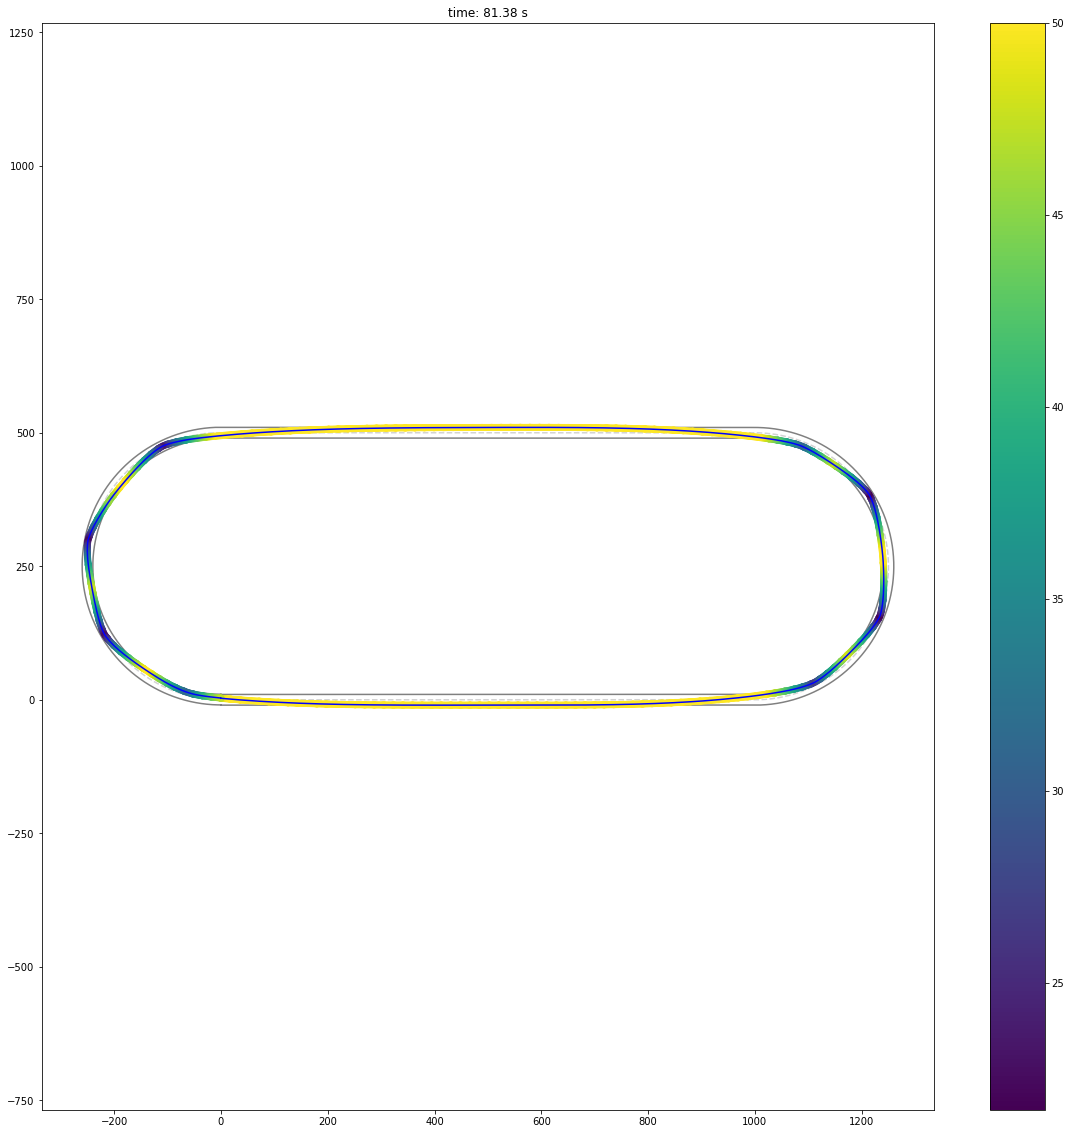

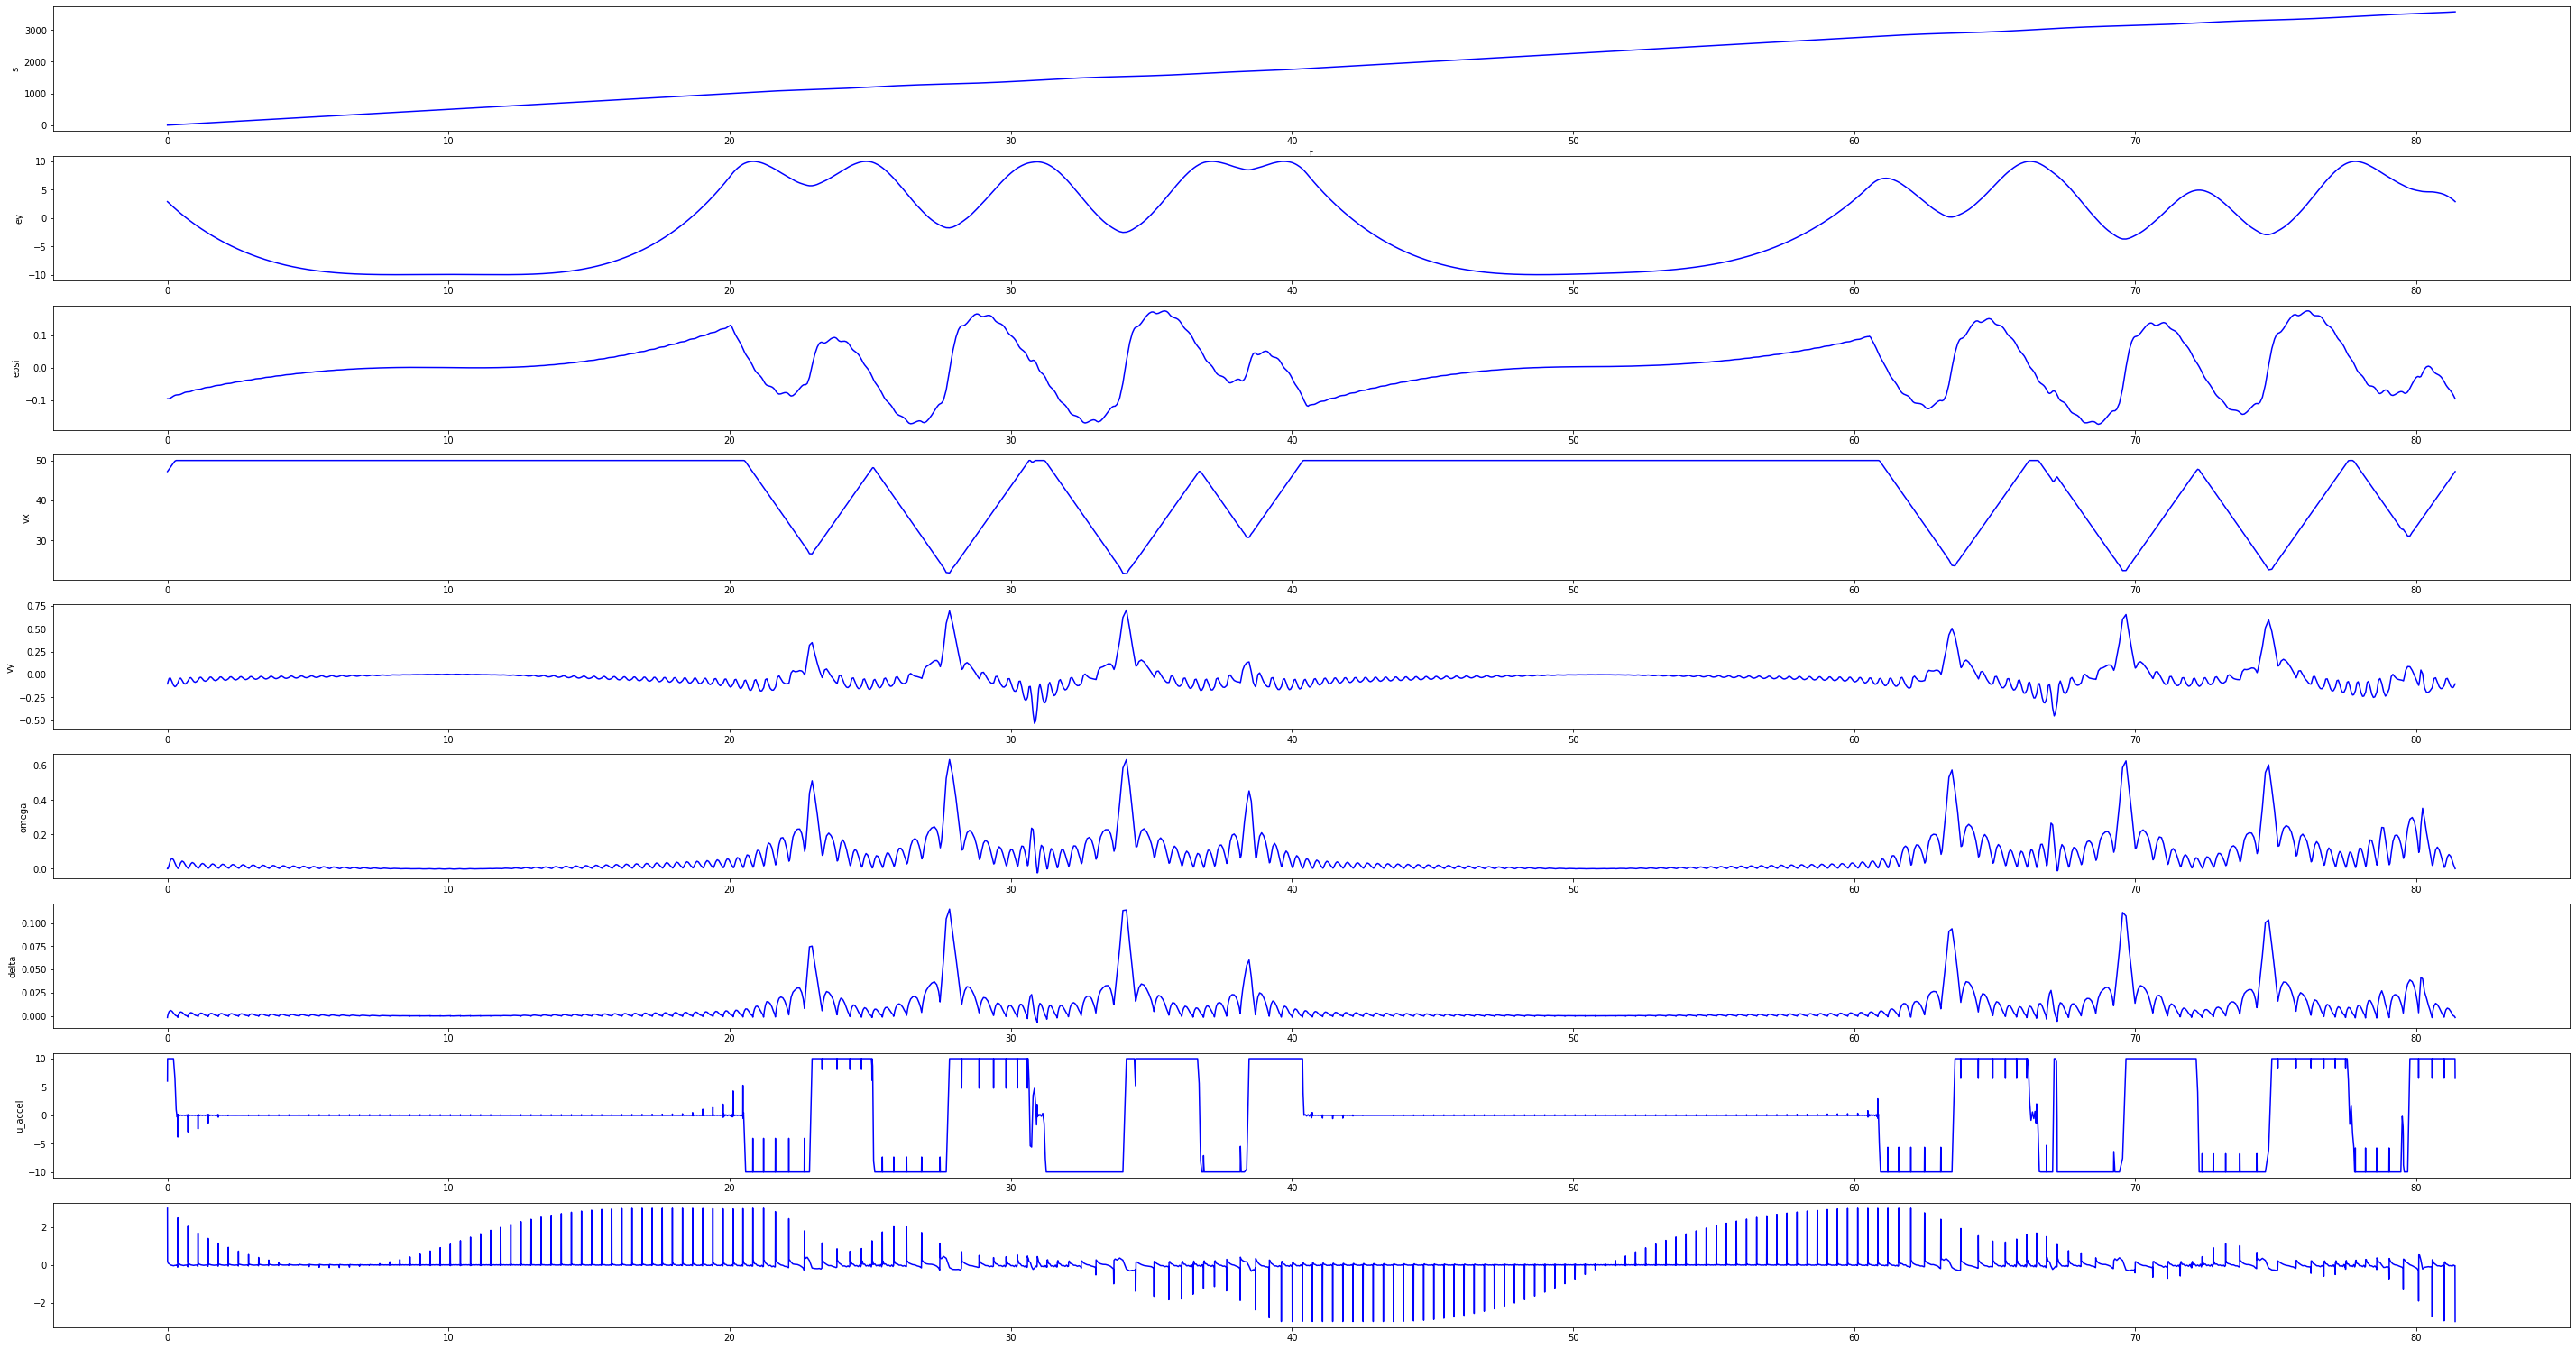

In [145]:
# Plot raceline
plot_racelines(track, raceline)

# Save raceline
# filename = 'raceline.npz'
# np.savez(filename, **raceline)

In [118]:
print(raceline['u_a'].shape)

(701,)


In [110]:
print(np.min(raceline['u_a'][:]))
print(np.max(raceline['u_a'][:]))

-1.5666264777126984
0.032162156859851125


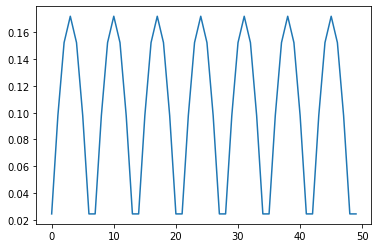

In [111]:
plt.plot(np.diff(raceline['t'])[:50])

In [101]:
print(np.min(np.diff(raceline['t'])))

0.01157138113011058


In [112]:
# print(model.s._discretization_info)
print(model.s._fe)

[0.0, 36.06864976560501, 72.13729953121002, 108.20594929681502, 144.27459906242004, 180.34324882802505, 216.41189859363004, 252.48054835923506, 288.5491981248401, 324.6178478904451, 360.6864976560501, 396.7551474216551, 432.8237971872601, 468.8924469528651, 504.9610967184701, 541.0297464840752, 577.0983962496801, 613.1670460152851, 649.2356957808902, 685.3043455464951, 721.3729953121002, 757.4416450777052, 793.5102948433102, 829.5789446089152, 865.6475943745202, 901.7162441401252, 937.7848939057302, 973.8535436713353, 1009.9221934369402, 1045.9908432025452, 1064.025168, 1082.0594929681504, 1118.1281427337553, 1154.1967924993603, 1190.2654422649653, 1226.3340920305702, 1262.4027417961754, 1298.4713915617804, 1334.5400413273853, 1370.6086910929903, 1406.6773408585955, 1442.7459906242004, 1478.8146403898054, 1514.8832901554104, 1550.9519399210153, 1587.0205896866205, 1623.0892394522255, 1659.1578892178304, 1695.2265389834354, 1731.2951887490403, 1767.3638385146455, 1803.4324882802505, 183

In [114]:
np.linspace(0, track.total_len, 100)

array([   0.        ,   36.06864977,   72.13729953,  108.2059493 ,
        144.27459906,  180.34324883,  216.41189859,  252.48054836,
        288.54919812,  324.61784789,  360.68649766,  396.75514742,
        432.82379719,  468.89244695,  504.96109672,  541.02974648,
        577.09839625,  613.16704602,  649.23569578,  685.30434555,
        721.37299531,  757.44164508,  793.51029484,  829.57894461,
        865.64759437,  901.71624414,  937.78489391,  973.85354367,
       1009.92219344, 1045.9908432 , 1082.05949297, 1118.12814273,
       1154.1967925 , 1190.26544226, 1226.33409203, 1262.4027418 ,
       1298.47139156, 1334.54004133, 1370.60869109, 1406.67734086,
       1442.74599062, 1478.81464039, 1514.88329016, 1550.95193992,
       1587.02058969, 1623.08923945, 1659.15788922, 1695.22653898,
       1731.29518875, 1767.36383851, 1803.43248828, 1839.50113805,
       1875.56978781, 1911.63843758, 1947.70708734, 1983.77573711,
       2019.84438687, 2055.91303664, 2091.98168641, 2128.05033